# 0) Notes  
- *res_price_per_sqft* does not appear to be calculated by REMM.
    - During base year prep, we manually calcualted this variable, then used local means to fill in missing values
- *unit_price_non_residential* is calculated by REMM, only records from the commercial lease table were used for estimation

In [270]:
import os
import numpy as np
import pandas as pd
from arcgis import GIS
from arcgis.features import GeoAccessor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

# show all columns
pd.options.display.max_columns = None
plt.rcParams.update({'figure.figsize': (14.0, 70.0)})
plt.rcParams.update({'figure.constrained_layout.h_pad': 1})
plt.rcParams.update({'font.size': 14})

# set random seed
seed = 425

In [271]:
outputs = r'.\Outputs'
if not os.path.exists(outputs):
    os.makedirs(outputs)

# 1) Data Prep

In [272]:
# read in inputs
b_vars = pd.read_csv(r".\Inputs\run423year2019allbuildings.csv") # building
n_vars = pd.read_csv(r".\Inputs\run423year2019nodevariables.csv") # node
z_vars = pd.read_csv(r".\Inputs\run423year2019zonalvariables.csv") # zone
c_vars = pd.read_csv(r".\Inputs\buildings_for_estimation_grouped_REMM2_v2.csv") # commercial

# remove simulated buildings
b_vars = b_vars[b_vars['note']=='base'].copy()

# rename identical columns
b_vars.rename({'population':'population_b'}, axis=1, inplace=True)
z_vars.rename({'population':'population_z'}, axis=1, inplace=True)

# rename duplicate columns in commercial data
c_vars.rename({'non_residential_sqft':'non_residential_sqft_c', 'building_type_id':'building_type_id_c', 'year_built':'year_built_c', 
               'unit_price_non_residential':'unit_price_non_residential_c', 'building_sqft':'building_sqft_c'}, axis=1, inplace=True)

# delete unneeded commercial columns
del c_vars['building_id']
del c_vars['X']
del c_vars['Y']
del c_vars['unit_price_residential']
del c_vars['stories']
del c_vars['residential_units']
del c_vars['improvement_value']

# remove store ids from c_vars
c_vars = c_vars[c_vars['parcel_id'] > 0].copy()
building_ids_c = c_vars['parcel_id'].to_list()


# join utm coords 
parcels = r"E:\REMM\Base_Year_Data_2019\v1\remm_base_year_20220513.gdb\parcels_2019"
parcels = pd.DataFrame.spatial.from_featureclass(parcels)[['parcel_id_REMM', 'x', 'y']].copy()
parcels.columns = ['parcel_id', 'utmxi','utmyi']
b_vars = b_vars.merge(parcels, on='parcel_id', how='left')
del parcels

In [273]:
# check for duplicates
b_vars_names = list(b_vars.columns)
n_vars_names = list(n_vars.columns)
z_vars_names = list(z_vars.columns)
c_vars_names = list(c_vars.columns)

all_names = b_vars_names + n_vars_names + z_vars_names + c_vars_names
seen = set()
dupes = [name for name in all_names if name in seen or seen.add(name)]
print(dupes)   

['node_id', 'zone_id', 'parcel_id']


In [274]:
# combine variables
tbl = b_vars.merge(z_vars, on='zone_id', how='left')
tbl = tbl.merge(n_vars, on='node_id', how='left')

tbl['log1p_fwy_exit_dist_tdm_output'] = np.log1p(tbl['fwy_exit_dist_tdm_output'])
tbl['log1p_rail_stn_dist'] =  np.log1p(tbl['rail_stn_dist'])
tbl['log1p_sqft_per_unit'] =  np.log1p(tbl['sqft_per_unit'])
tbl['log1p_university_dist'] = np.log1p(tbl['university_dist'])
tbl['log1p_real_far'] = np.log1p(tbl['real_far'])
tbl['log1p_building_age'] = np.log1p(tbl['building_age'])

tbl.loc[(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 1
tbl.loc[~(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 0

tbl.loc[(tbl['year_built'] < 21), 'year_built_lt_1945'] = 1
tbl.loc[~(tbl['year_built'] < 21), 'year_built_lt_1945'] = 0

# fill NAs
tbl.fillna(0, inplace=True)

# # set building id as index
# tbl.set_index('building_id', inplace=True)

In [275]:
# create tables for each county
tbl_57 = tbl[tbl['county_id']==57].copy()
tbl_11 = tbl[tbl['county_id']==11].copy()
tbl_35 = tbl[tbl['county_id']==35].copy()
tbl_49 = tbl[tbl['county_id']==49].copy()

# join the commercial table. NOTE: This will create additional records
tbl = tbl.merge(c_vars, on='parcel_id', how='left')

# fill NAs
tbl.fillna(0, inplace=True)


# create separate commercial table for each county
comm_57 = tbl[(tbl['county_id']==57) & (tbl['building_id'].isin(building_ids_c) == True)].copy()
comm_11 = tbl[(tbl['county_id']==11) & (tbl['building_id'].isin(building_ids_c) == True)].copy()
comm_35 = tbl[(tbl['county_id']==35) & (tbl['building_id'].isin(building_ids_c) == True)].copy()
comm_49 = tbl[(tbl['county_id']==49) & (tbl['building_id'].isin(building_ids_c) == True)].copy()

# tbl_57.to_csv(os.path.join(outputs, 'buildings_nodes_zones_57.csv'), index=False)
# tbl_11.to_csv(os.path.join(outputs, 'buildings_nodes_zones_11.csv'), index=False)
# tbl_35.to_csv(os.path.join(outputs, 'buildings_nodes_zones_35.csv'), index=False)
# tbl_49.to_csv(os.path.join(outputs, 'buildings_nodes_zones_49.csv'),index=False)

In [276]:
drop_vars = ['parcel_id', 
             'zone_id', 
             'node_id', 
             'note', 
             'zone_1212',
             'unit_price_non_residential',
             'building_type_id',
             'residential_price',
             'non_residential_price',
             'building_sqft',
             'general_type',
             'sqft_per_unit',
             'county_id',
             'residential_sqft',
             'is_sf',
             'is_mf',
             'is_industrial',
             'is_retail',
             'is_office',
             'is_govt',
             'is_mixeduse',
             'is_other',
             'residential_sales_price_sqft',
             'unit_price_residential',
             'utmxi',
             'utmyi'
            ]
        

In [277]:
# # drop columns
# tbl_57.drop(vars_to_exclude, axis=1, inplace=True)
# tbl_11.drop(vars_to_exclude, axis=1, inplace=True)
# tbl_35.drop(vars_to_exclude, axis=1, inplace=True)
# tbl_49.drop(vars_to_exclude, axis=1, inplace=True)

# 2) Analysis

# Single Family (Residential Unit Price)

###  Weber

In [278]:
# arguments - check these
data = tbl_57
y_var_name = 'res_price_per_sqft'

In [279]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
sf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = sf.copy()
y_var = sf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:44987
Testing sample size:14996


In [280]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.928
Mean Squared Error: 2.536
R-squared scores: 0.981


Text(0.5, 0, 'Random Forest Feature Importance')

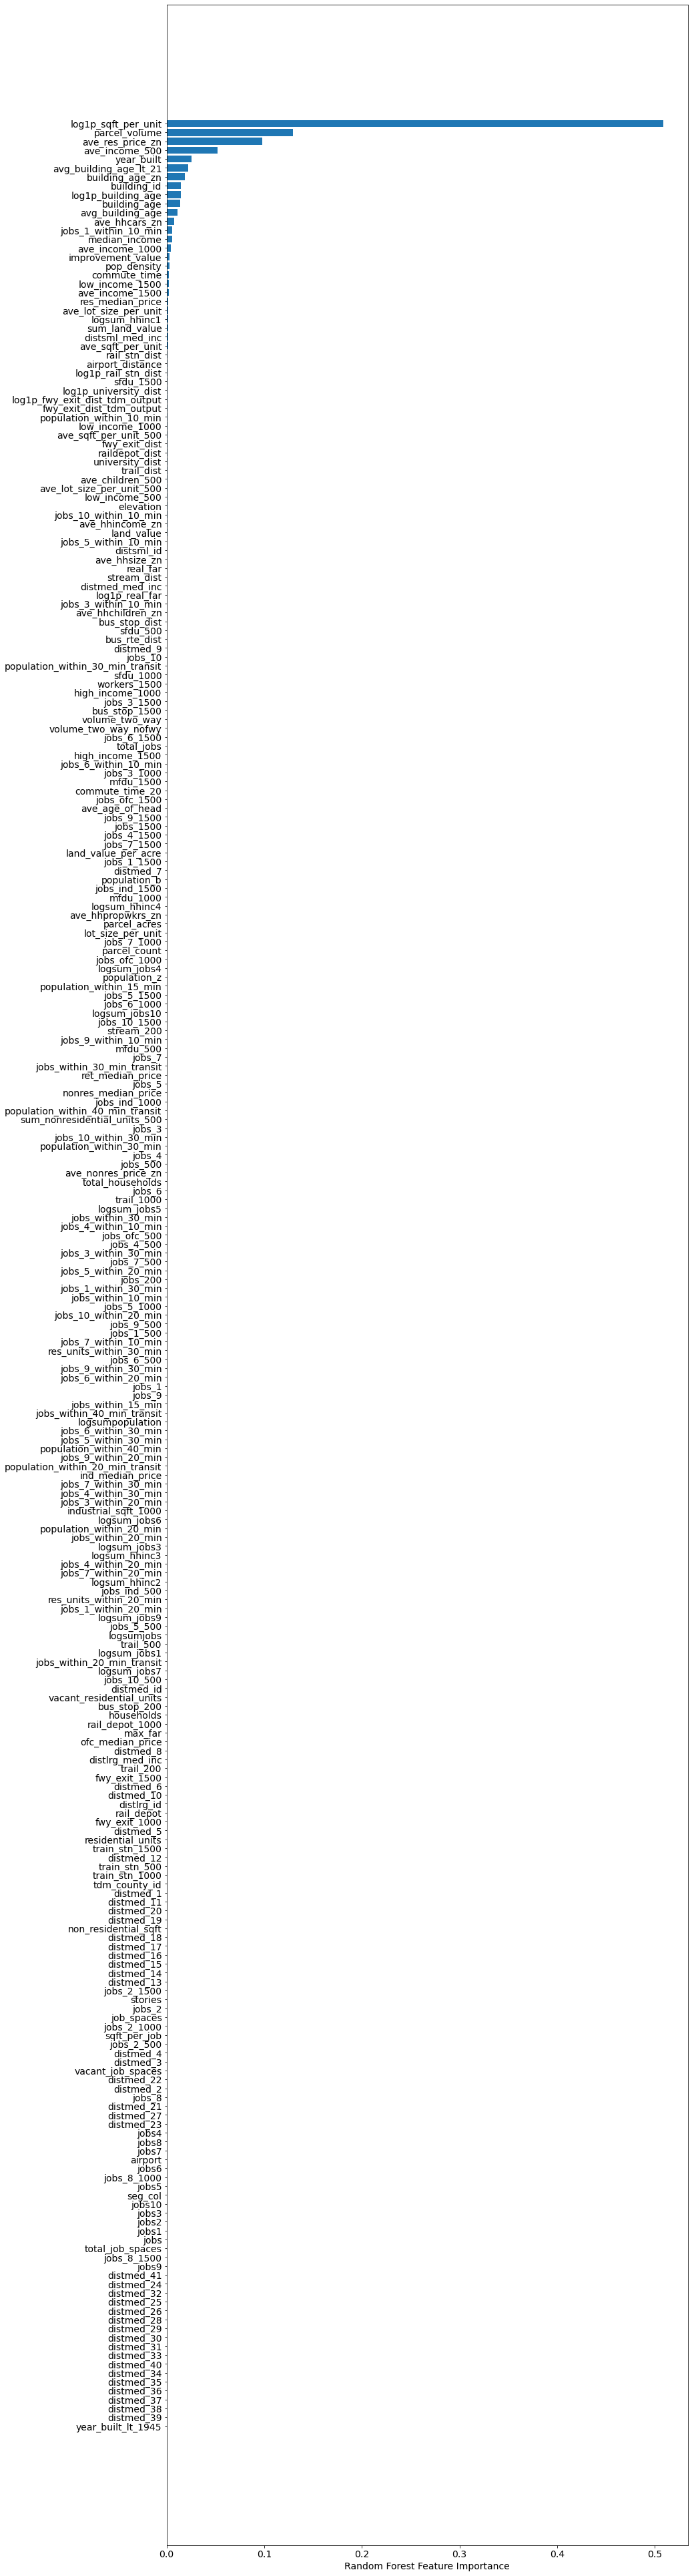

In [281]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Davis

In [282]:
# arguments - check these
data = tbl_11
y_var_name = 'res_price_per_sqft'

In [283]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
sf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = sf.copy()
y_var = sf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:61524
Testing sample size:20509


In [284]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.932
Mean Squared Error: 4.825
R-squared scores: 0.988


Text(0.5, 0, 'Random Forest Feature Importance')

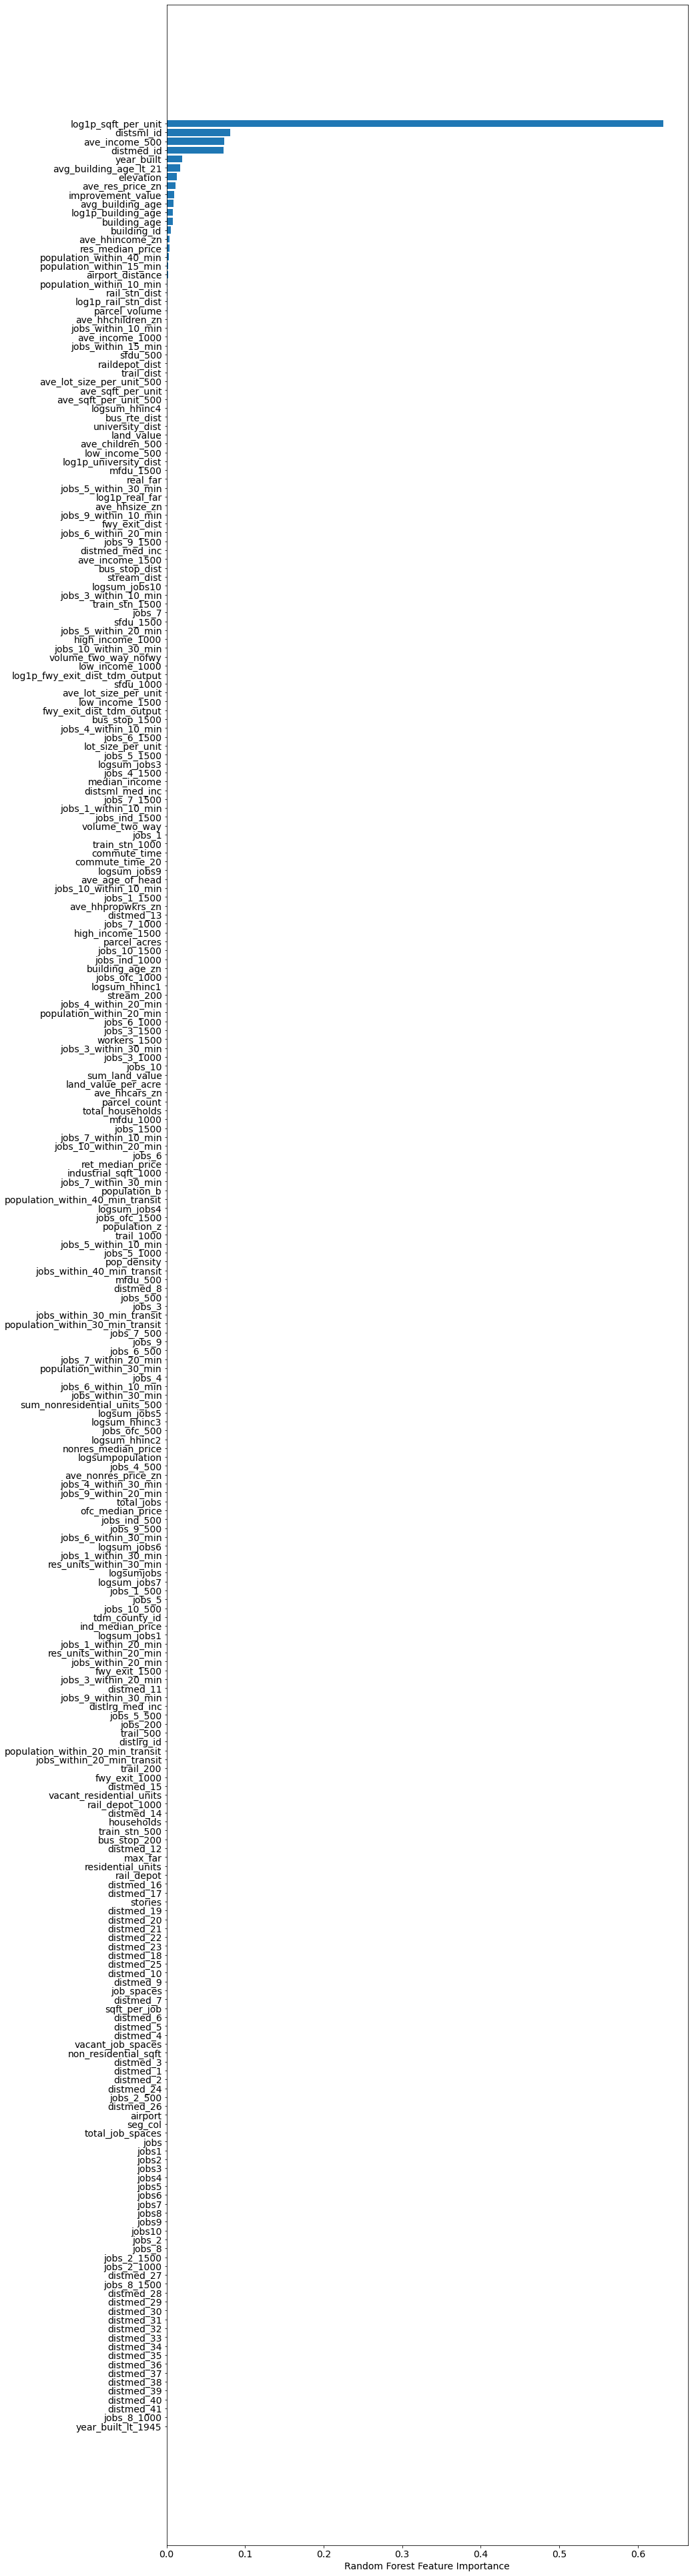

In [285]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [286]:
# arguments - check these
data = tbl_35
y_var_name = 'res_price_per_sqft'

In [287]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
sf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = sf.copy()
y_var = sf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:176034
Testing sample size:58678


In [288]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.367
Mean Squared Error: 1.793
R-squared scores: 0.992


Text(0.5, 0, 'Random Forest Feature Importance')

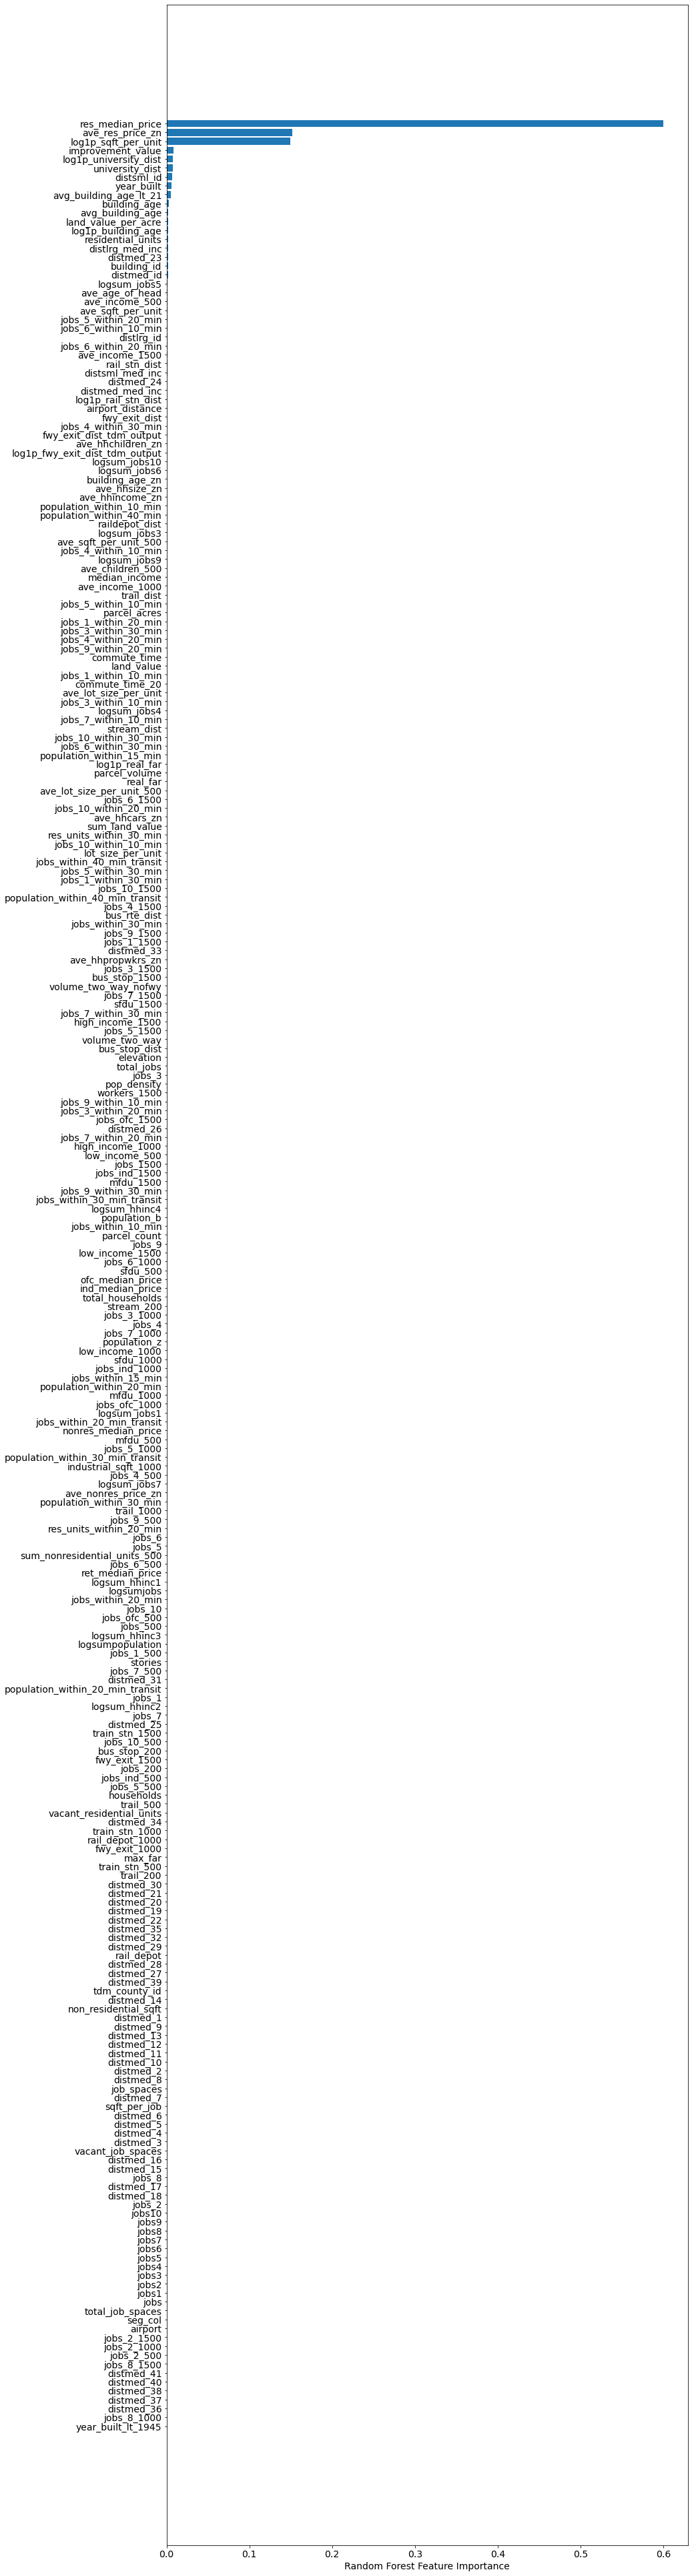

In [289]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [290]:
# arguments - check these
data = tbl_49
y_var_name = 'res_price_per_sqft'

In [291]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
sf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = sf.copy()
y_var = sf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:91540
Testing sample size:30514


In [292]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.356
Mean Squared Error: 1.393
R-squared scores: 0.982


Text(0.5, 0, 'Random Forest Feature Importance')

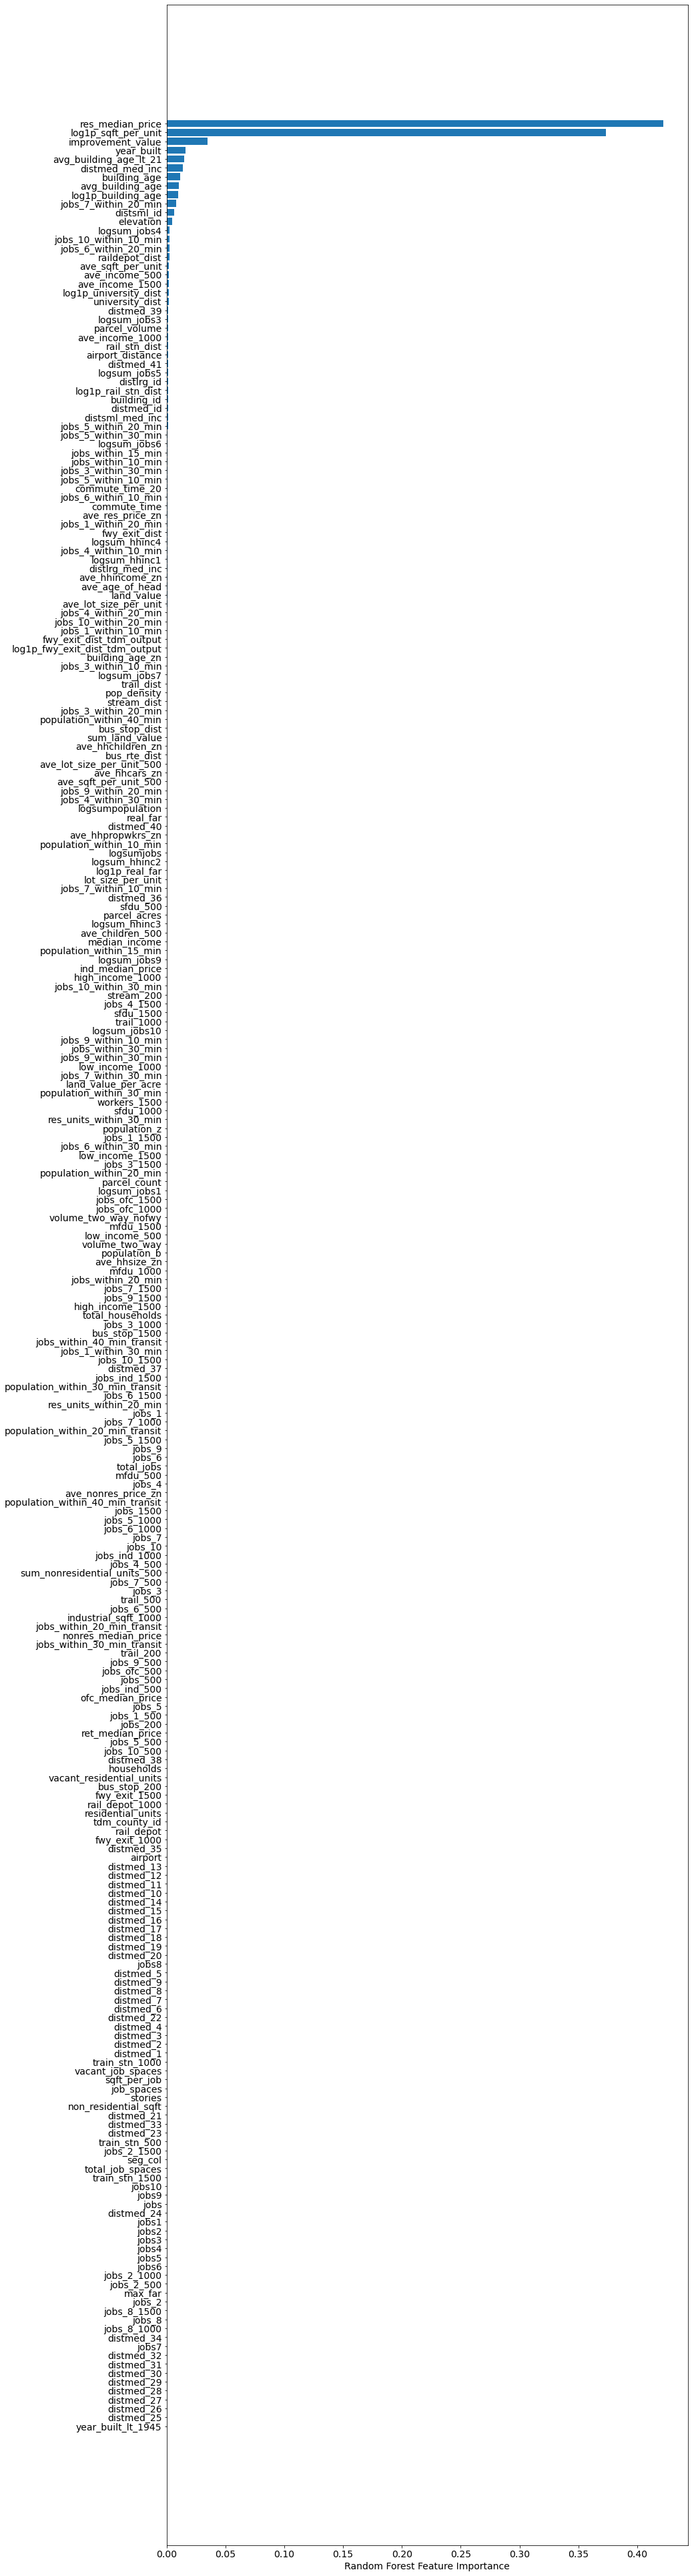

In [293]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Multifamily (Residential Unit Price)

###  Weber

In [294]:
# arguments - check these
data = tbl_57
y_var_name = 'res_price_per_sqft'

In [295]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
mf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = mf.copy()
y_var = mf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:1832
Testing sample size:611


In [296]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 2.376
Mean Squared Error: 27.518
R-squared scores: 0.945


Text(0.5, 0, 'Random Forest Feature Importance')

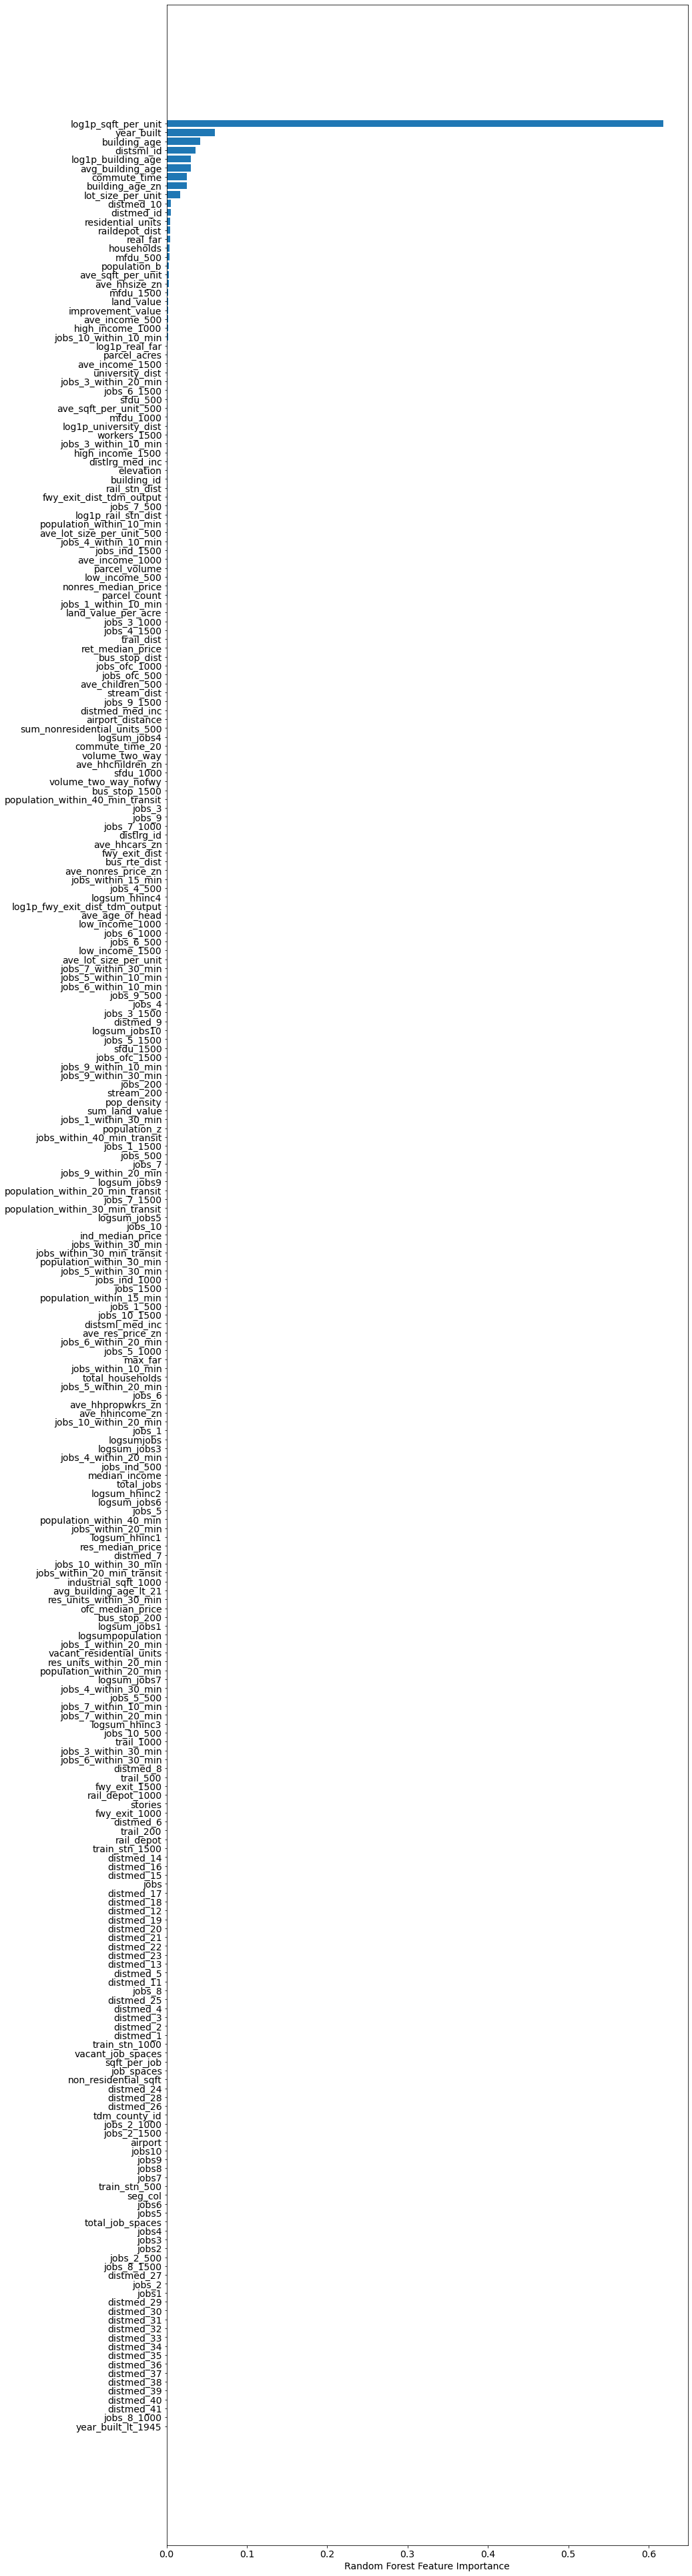

In [297]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Davis

In [298]:
# arguments - check these
data = tbl_11
y_var_name = 'res_price_per_sqft'

In [299]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
mf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = mf.copy()
y_var = mf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:1428
Testing sample size:477


In [300]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 3.718
Mean Squared Error: 91.323
R-squared scores: 0.772


Text(0.5, 0, 'Random Forest Feature Importance')

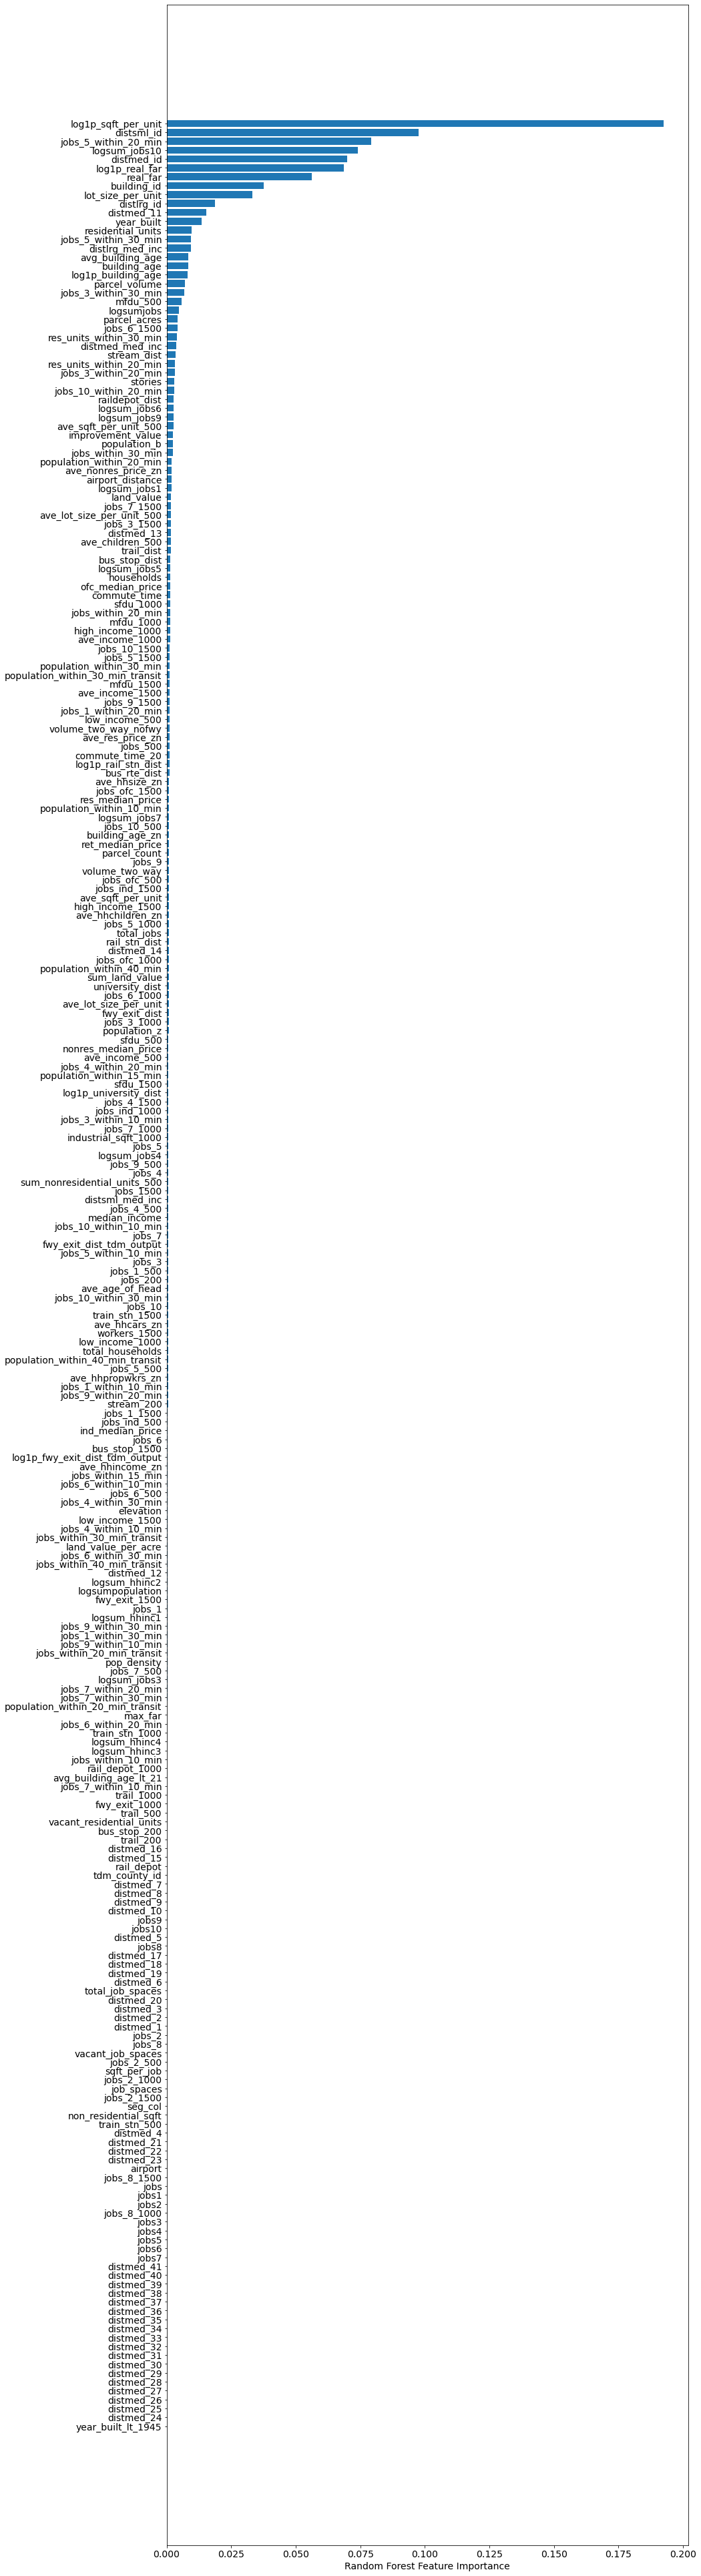

In [301]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [302]:
# arguments - check these
data = tbl_35
y_var_name = 'res_price_per_sqft'

In [303]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
mf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = mf.copy()
y_var = mf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:8035
Testing sample size:2679


In [304]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 2.919
Mean Squared Error: 54.706
R-squared scores: 0.911


Text(0.5, 0, 'Random Forest Feature Importance')

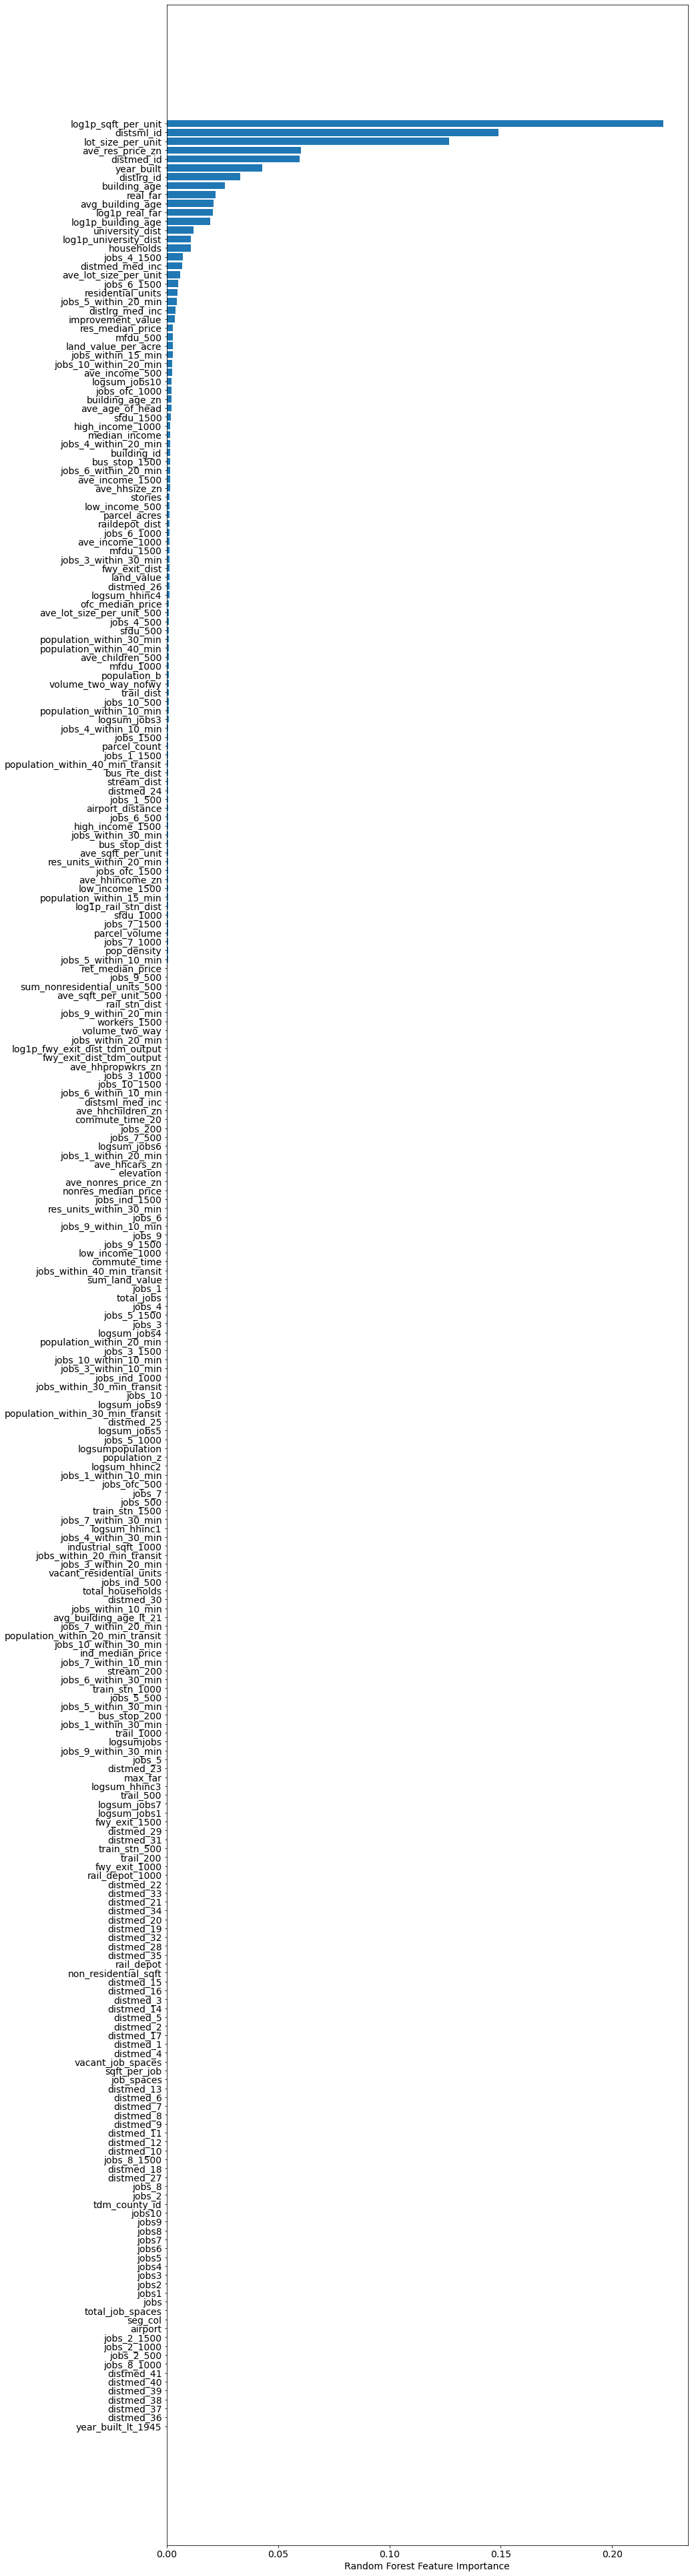

In [305]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [306]:
# arguments - check these
data = tbl_49
y_var_name = 'res_price_per_sqft'

In [307]:
# filters
mf = data[(data['building_type_id'] == 2) & (data['res_price_per_sqft'] > 0)].copy()

# drop unneeded columns
mf.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = mf.copy()
y_var = mf[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:8279
Testing sample size:2760


In [308]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1.322
Mean Squared Error: 11.412
R-squared scores: 0.936


Text(0.5, 0, 'Random Forest Feature Importance')

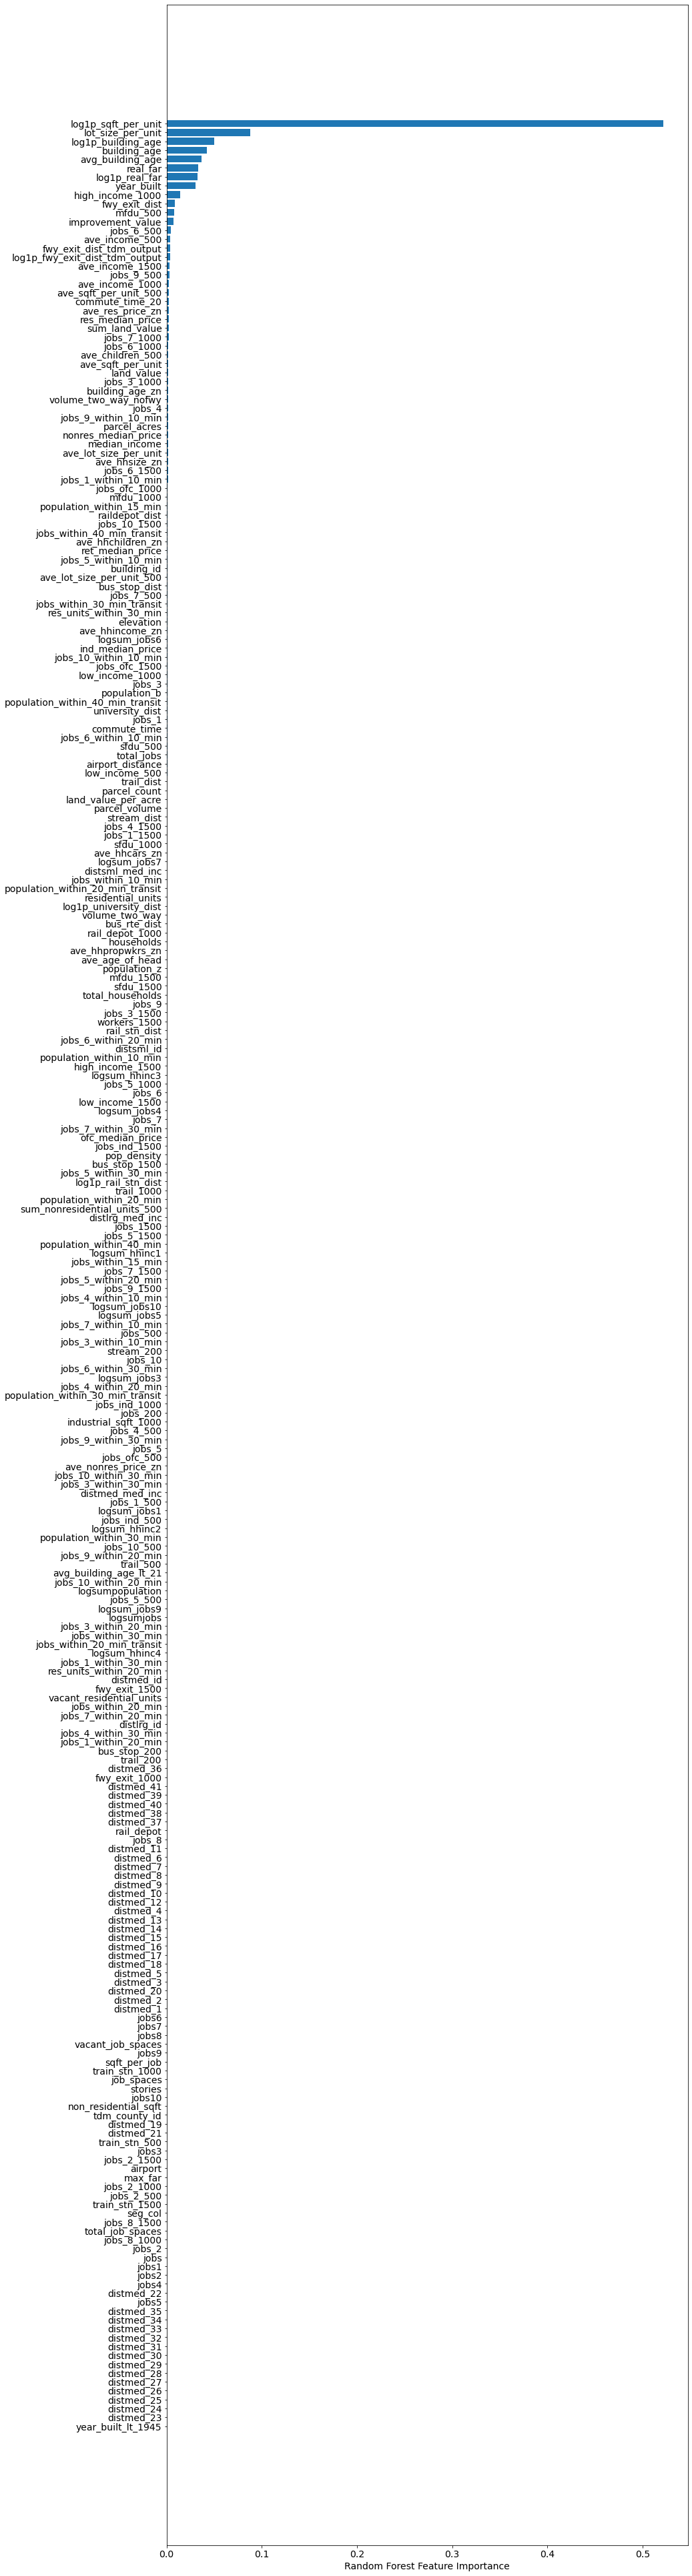

In [309]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Retail

In [310]:
drop_vars = ['parcel_id', 
             'zone_id', 
             'node_id', 
             'note', 
             'zone_1212',
             'unit_price_non_residential',
             'building_type_id',
             'residential_price',
             'non_residential_price',
             'building_sqft',
             'general_type',
             'sqft_per_unit',
             'county_id',
             'residential_sqft',
             'is_sf',
             'is_mf',
             'is_industrial',
             'is_retail',
             'is_office',
             'is_govt',
             'is_mixeduse',
             'is_other',
             'residential_sales_price_sqft',
             'unit_price_residential',
             'utmxi',
             'utmyi',
             'non_residential_sqft_c', 
             'building_type_id_c',  
             'building_sqft_c',
             'MonRentPSF',
             'YrRentPSF' ,
             'lease_type',
             'sale_lease' ,
             'trans_year'
            ]

# All Counties

In [311]:
# arguments - check these
data = pd.concat([comm_57, comm_11, comm_35, comm_49])
y_var_name = 'unit_price_non_residential_c'

In [312]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
ret.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = ret.copy()
y_var = ret[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:837
Testing sample size:279


In [313]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1751838.697
Mean Squared Error: 18344466402221.555
R-squared scores: 0.584


Text(0.5, 0, 'Random Forest Feature Importance')

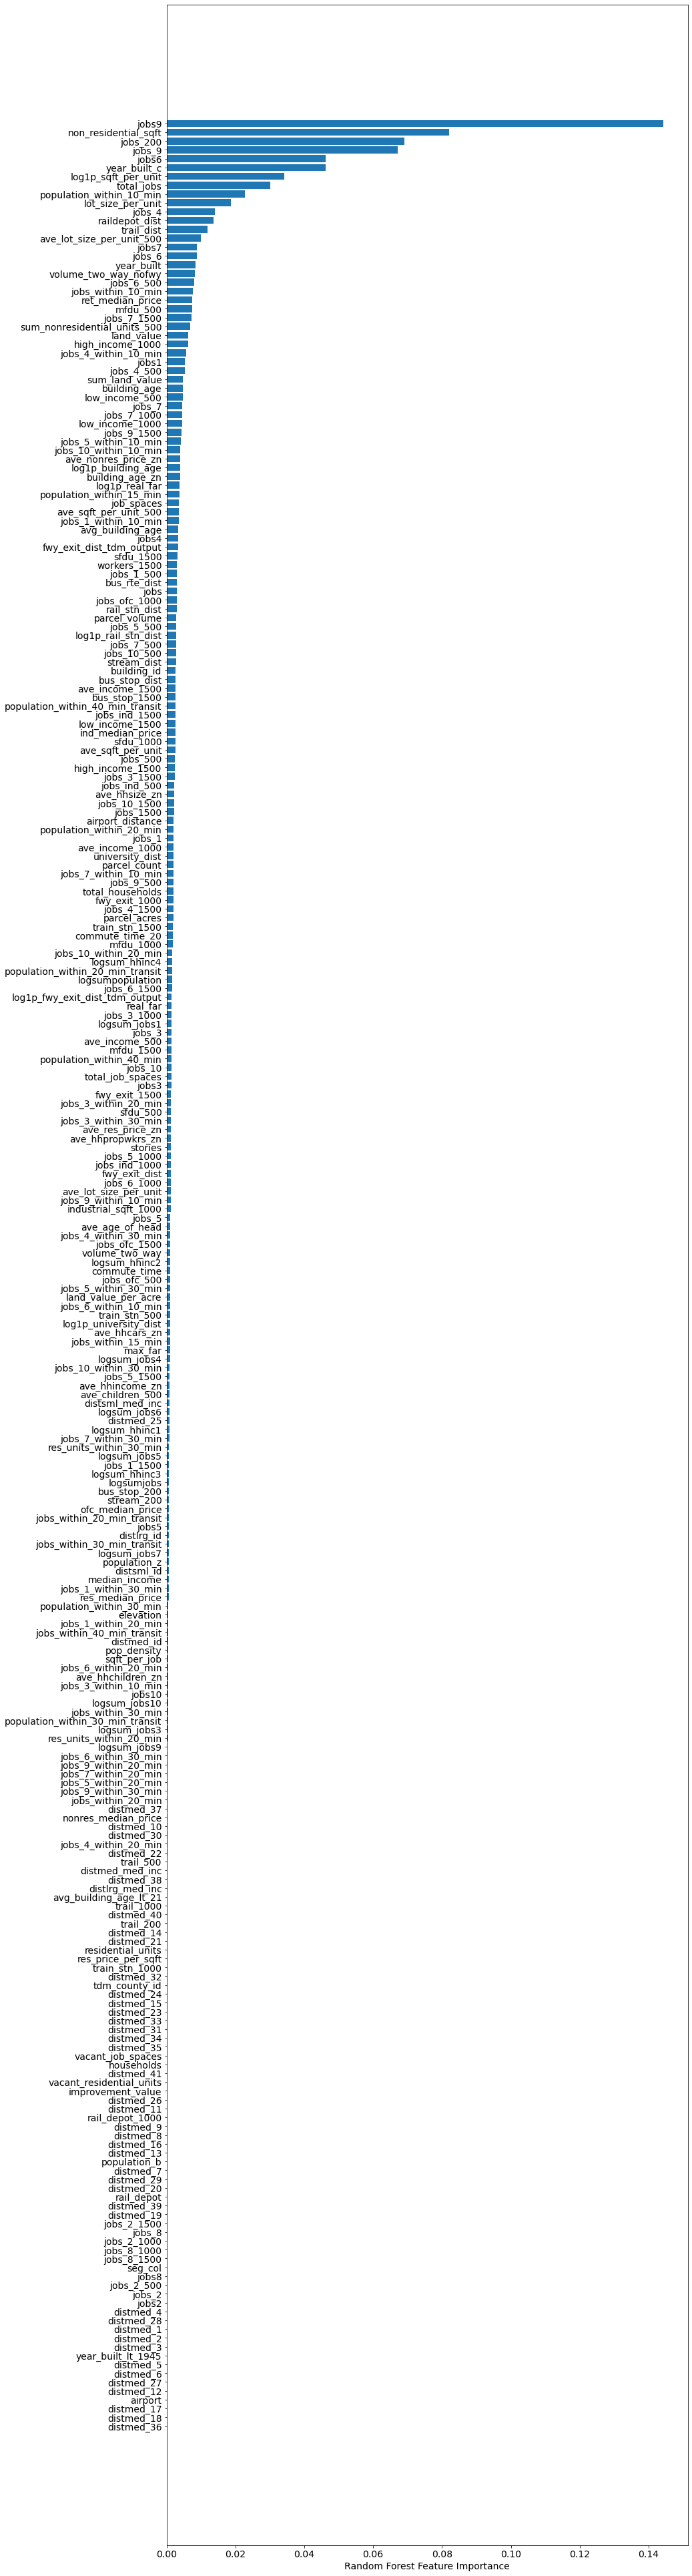

In [314]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

###  Weber & Davis

In [315]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var_name = 'unit_price_non_residential_c'

In [316]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
ret.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = ret.copy()
y_var = ret[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:153
Testing sample size:52


In [317]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1458384.538
Mean Squared Error: 43351109819638.34
R-squared scores: 0.076


Text(0.5, 0, 'Random Forest Feature Importance')

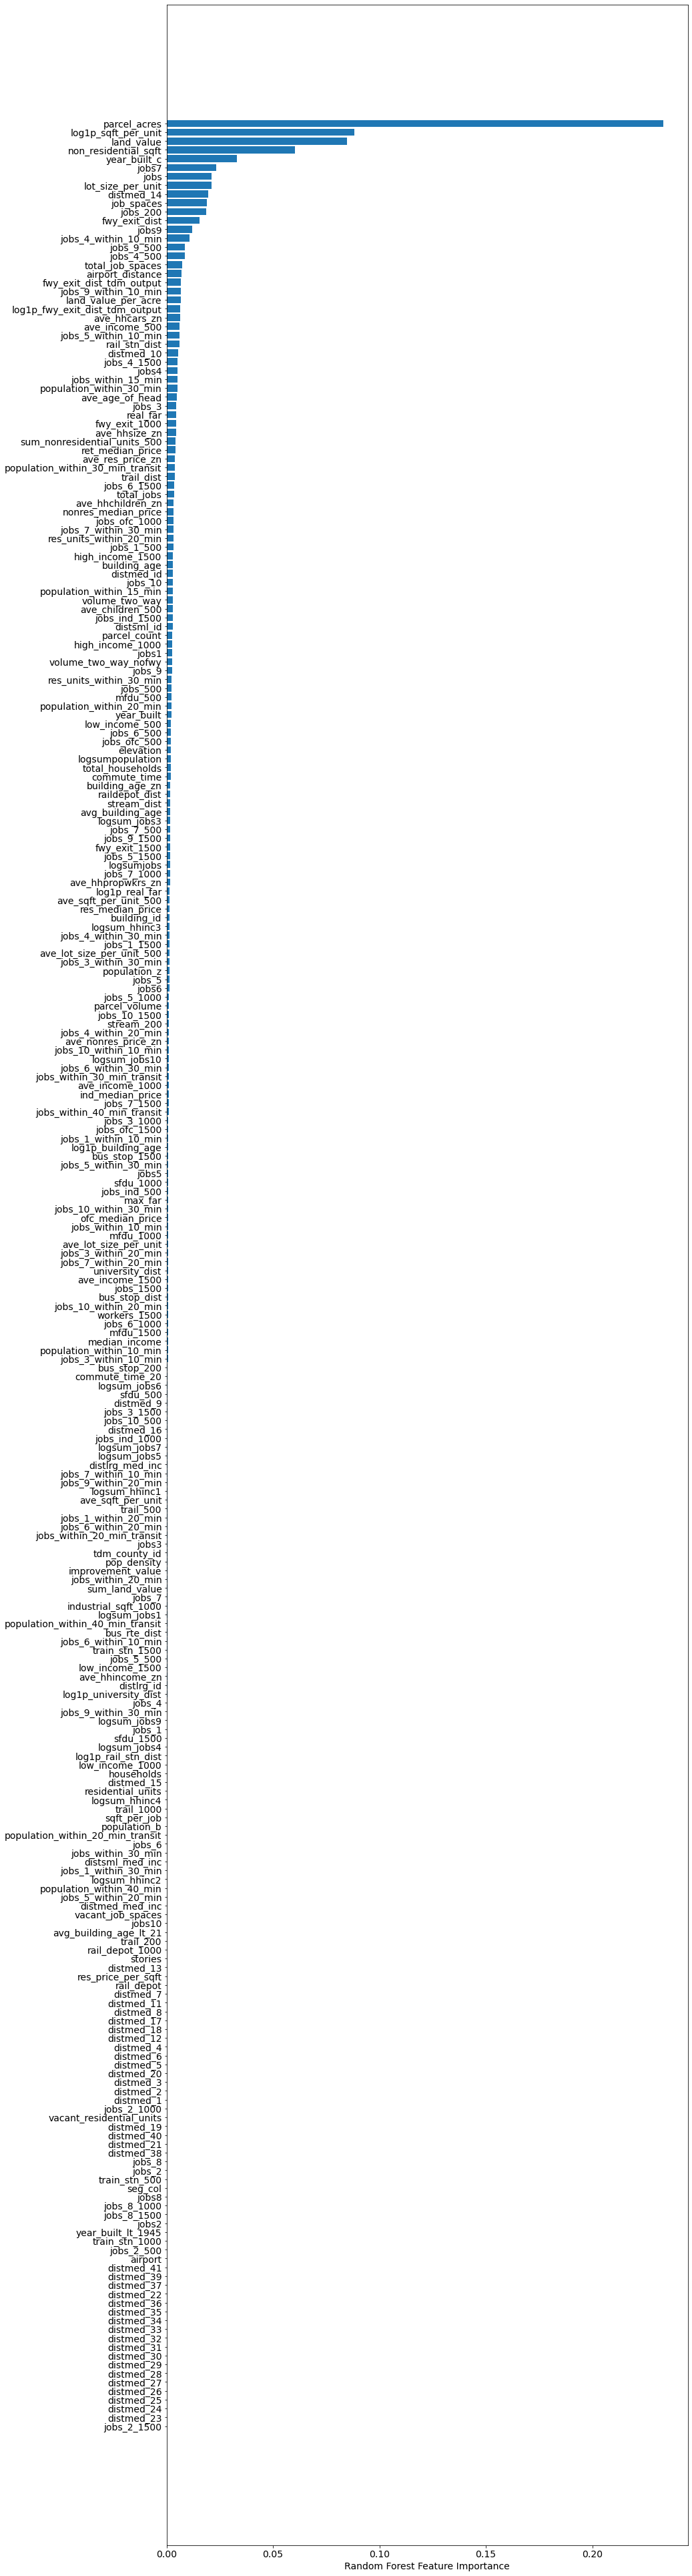

In [318]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [319]:
# arguments - check these
data = comm_35
y_var_name = 'unit_price_non_residential_c'

In [320]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
ret.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = ret.copy()
y_var = ret[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:479
Testing sample size:160


In [321]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1684216.324
Mean Squared Error: 14644168147381.896
R-squared scores: 0.705


Text(0.5, 0, 'Random Forest Feature Importance')

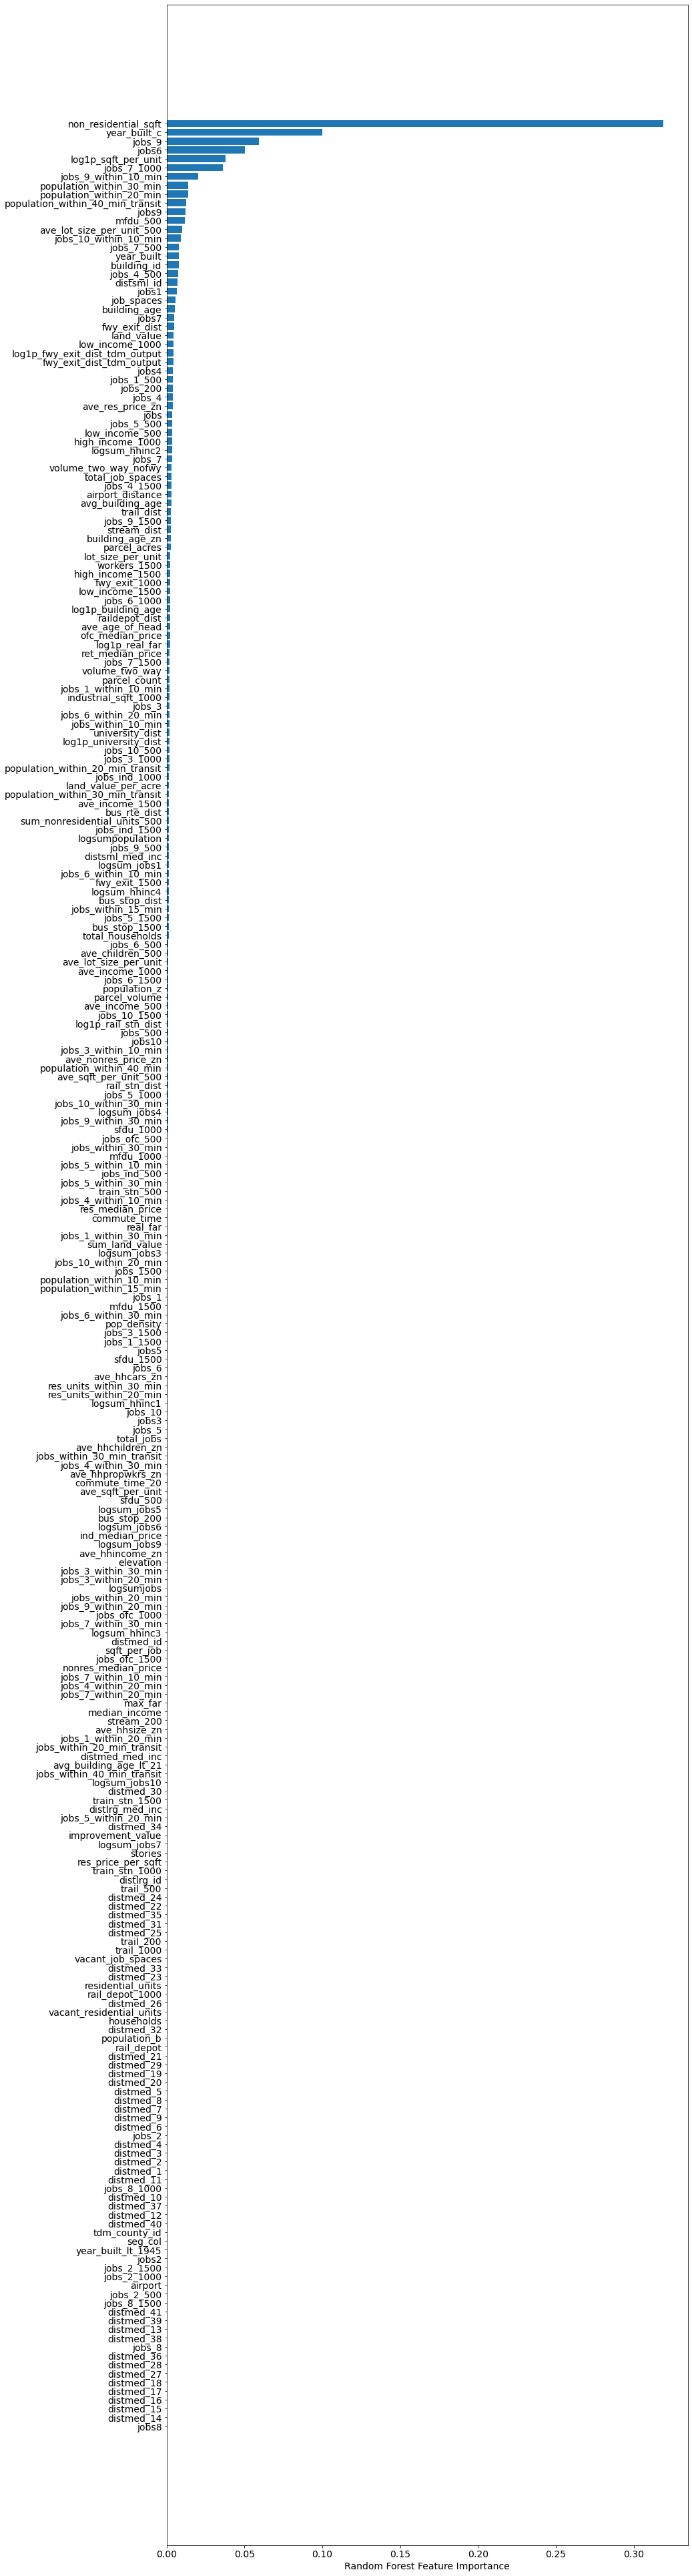

In [322]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [323]:
# arguments - check these
data = comm_49
y_var_name = 'unit_price_non_residential_c'

In [324]:
# filters
ret = data[(data['building_type_id_c'] == 4) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
ret.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = ret.copy()
y_var = ret[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:204
Testing sample size:68


In [325]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 1076458.122
Mean Squared Error: 6739639395806.274
R-squared scores: 0.635


Text(0.5, 0, 'Random Forest Feature Importance')

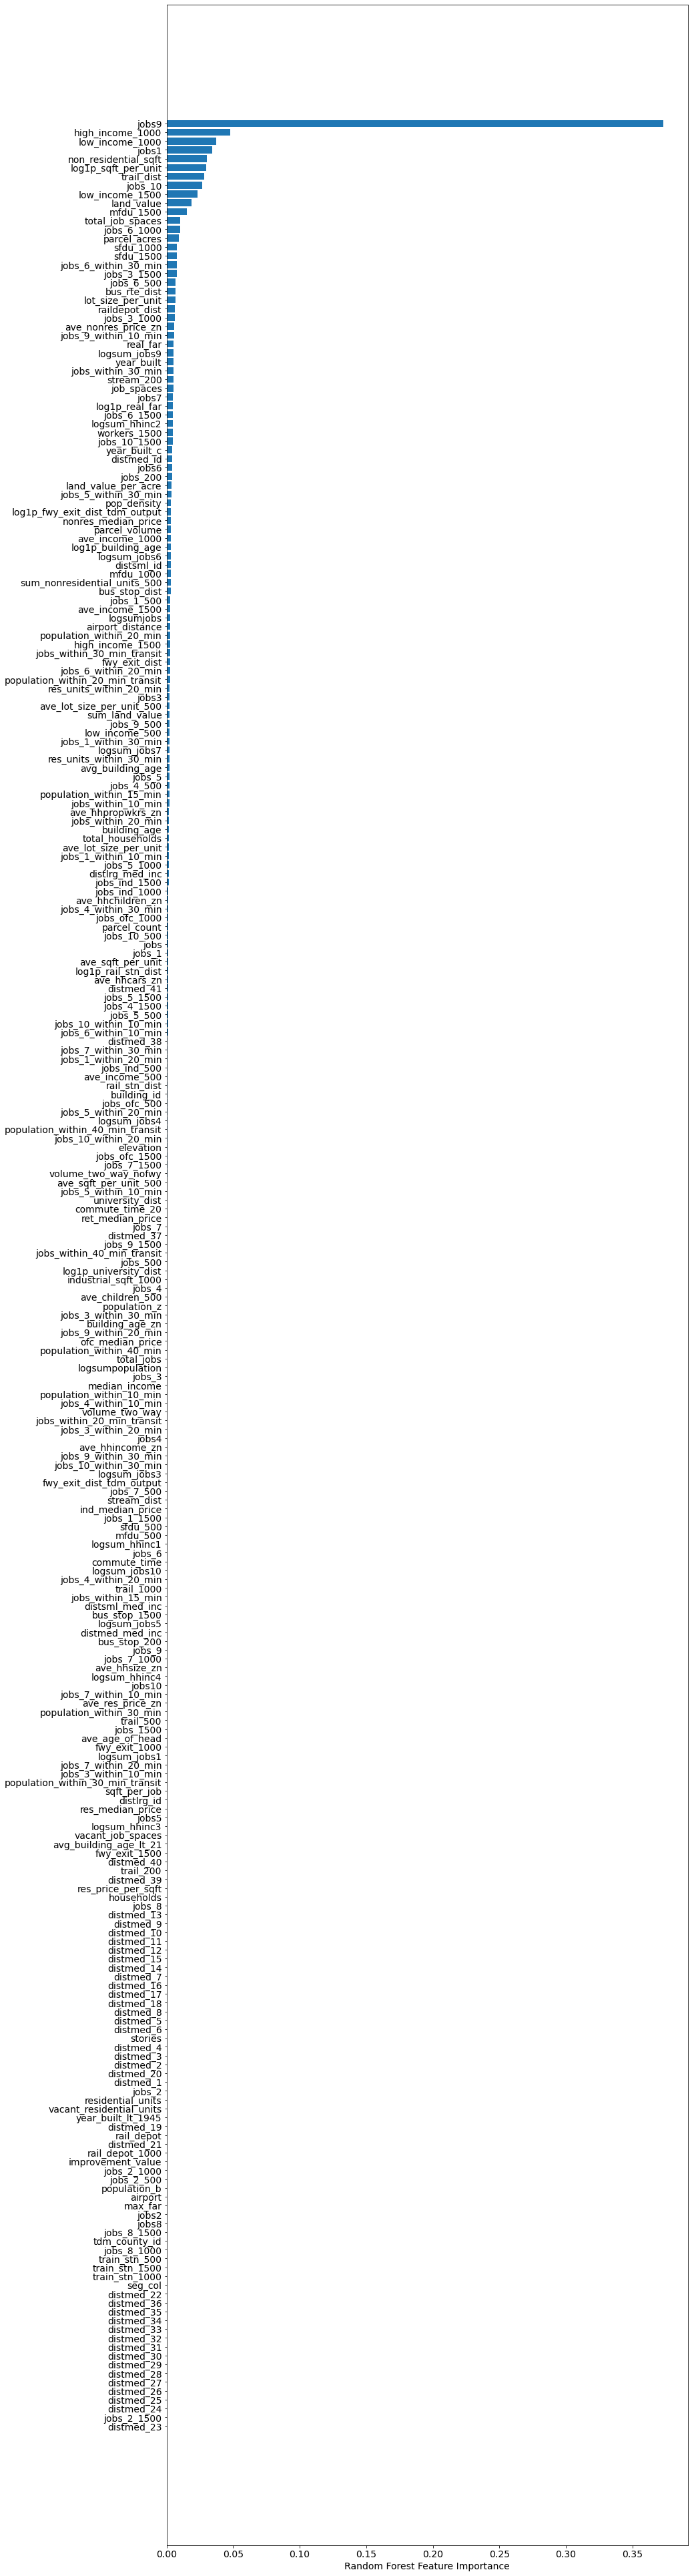

In [326]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Office

###  Weber & Davis

In [327]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var_name = 'unit_price_non_residential_c'

In [328]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
off.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = off.copy()
y_var = off[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:155
Testing sample size:52


In [329]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 233623.918
Mean Squared Error: 263236667215.678
R-squared scores: 0.088


Text(0.5, 0, 'Random Forest Feature Importance')

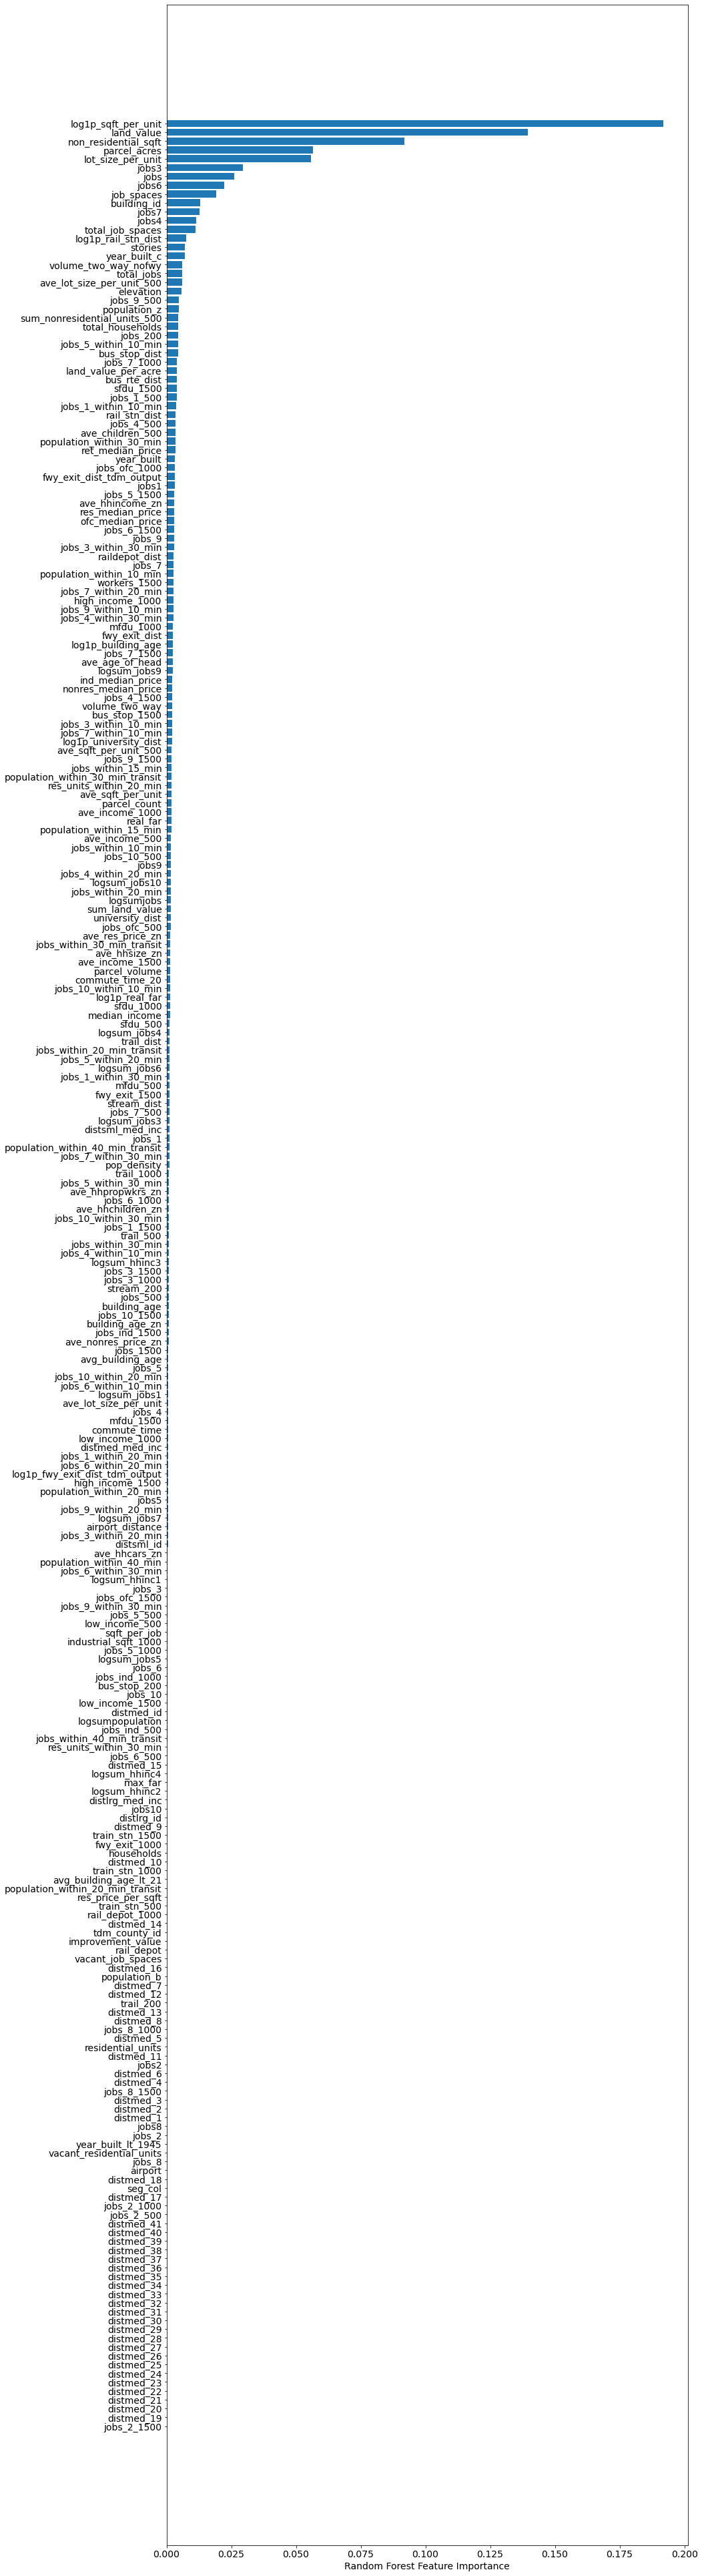

In [330]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [331]:
# arguments - check these
data = comm_35
y_var_name = 'unit_price_non_residential_c'

In [332]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
off.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = off.copy()
y_var = off[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:696
Testing sample size:233


In [333]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 395755.861
Mean Squared Error: 649642387556.874
R-squared scores: 0.902


Text(0.5, 0, 'Random Forest Feature Importance')

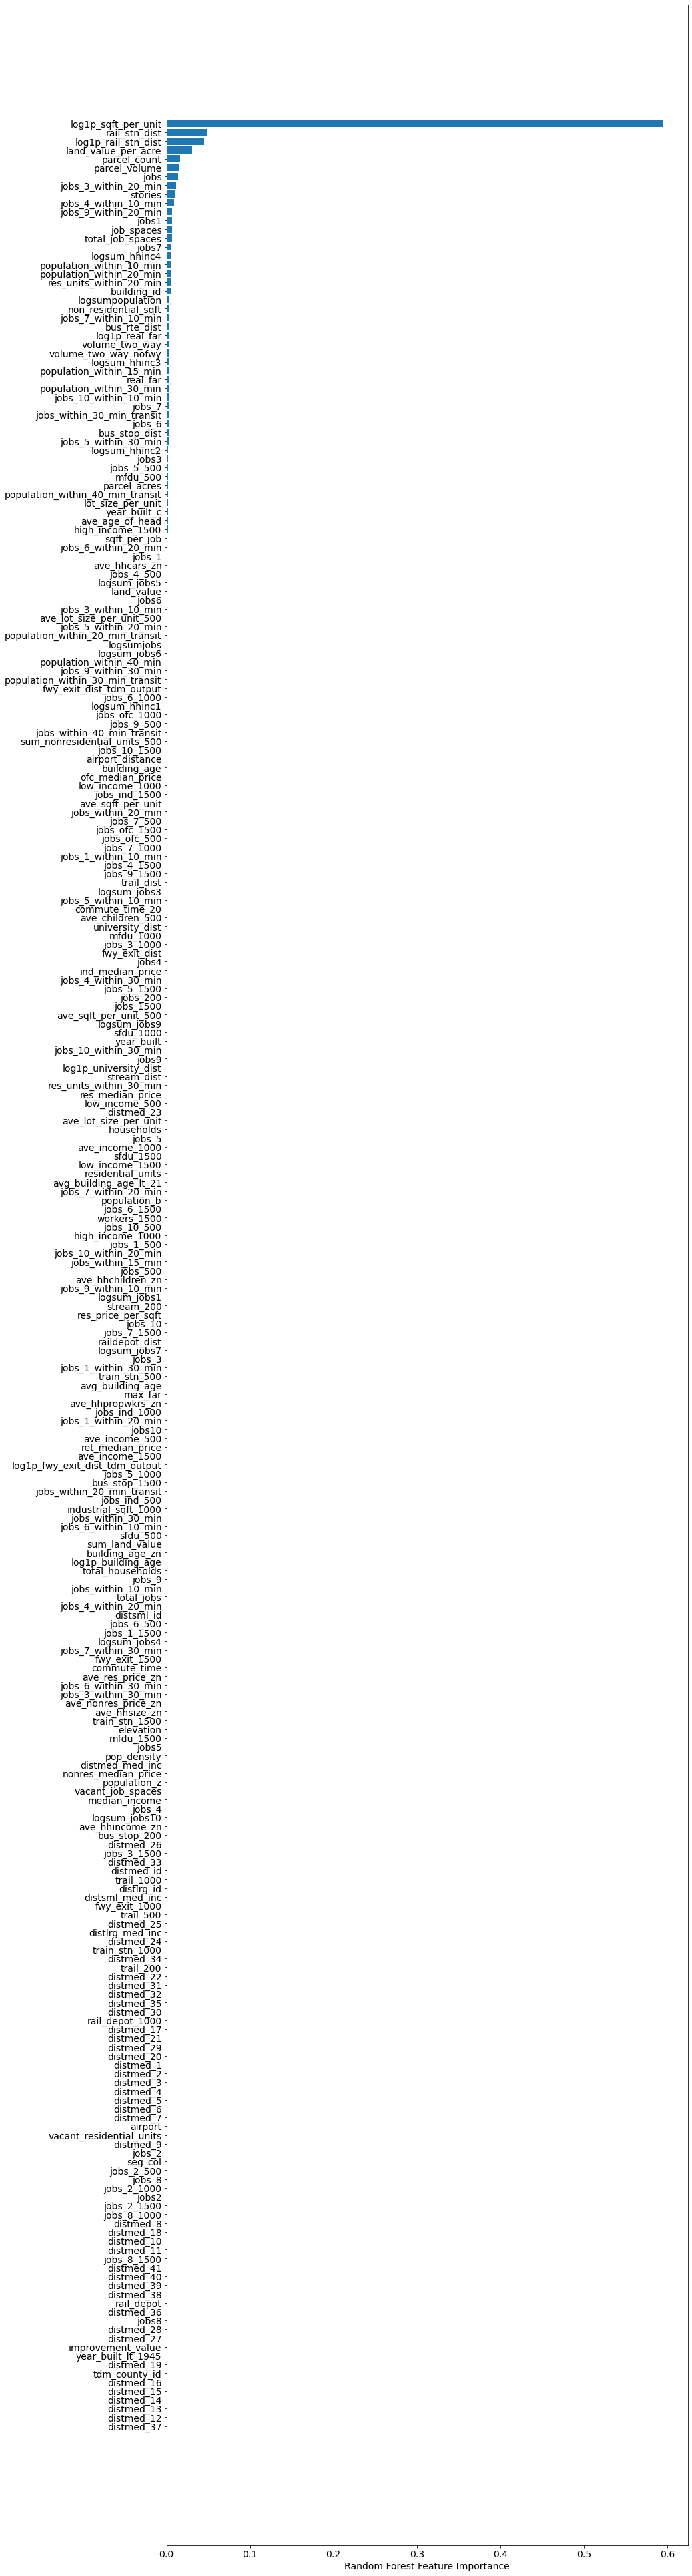

In [334]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [335]:
# arguments - check these
data = comm_49
y_var_name = 'unit_price_non_residential_c'

In [336]:
# filters
off = data[(data['building_type_id_c'] == 5) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
off.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = off.copy()
y_var = off[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:212
Testing sample size:71


In [337]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 220501.707
Mean Squared Error: 307558732193.419
R-squared scores: 0.748


Text(0.5, 0, 'Random Forest Feature Importance')

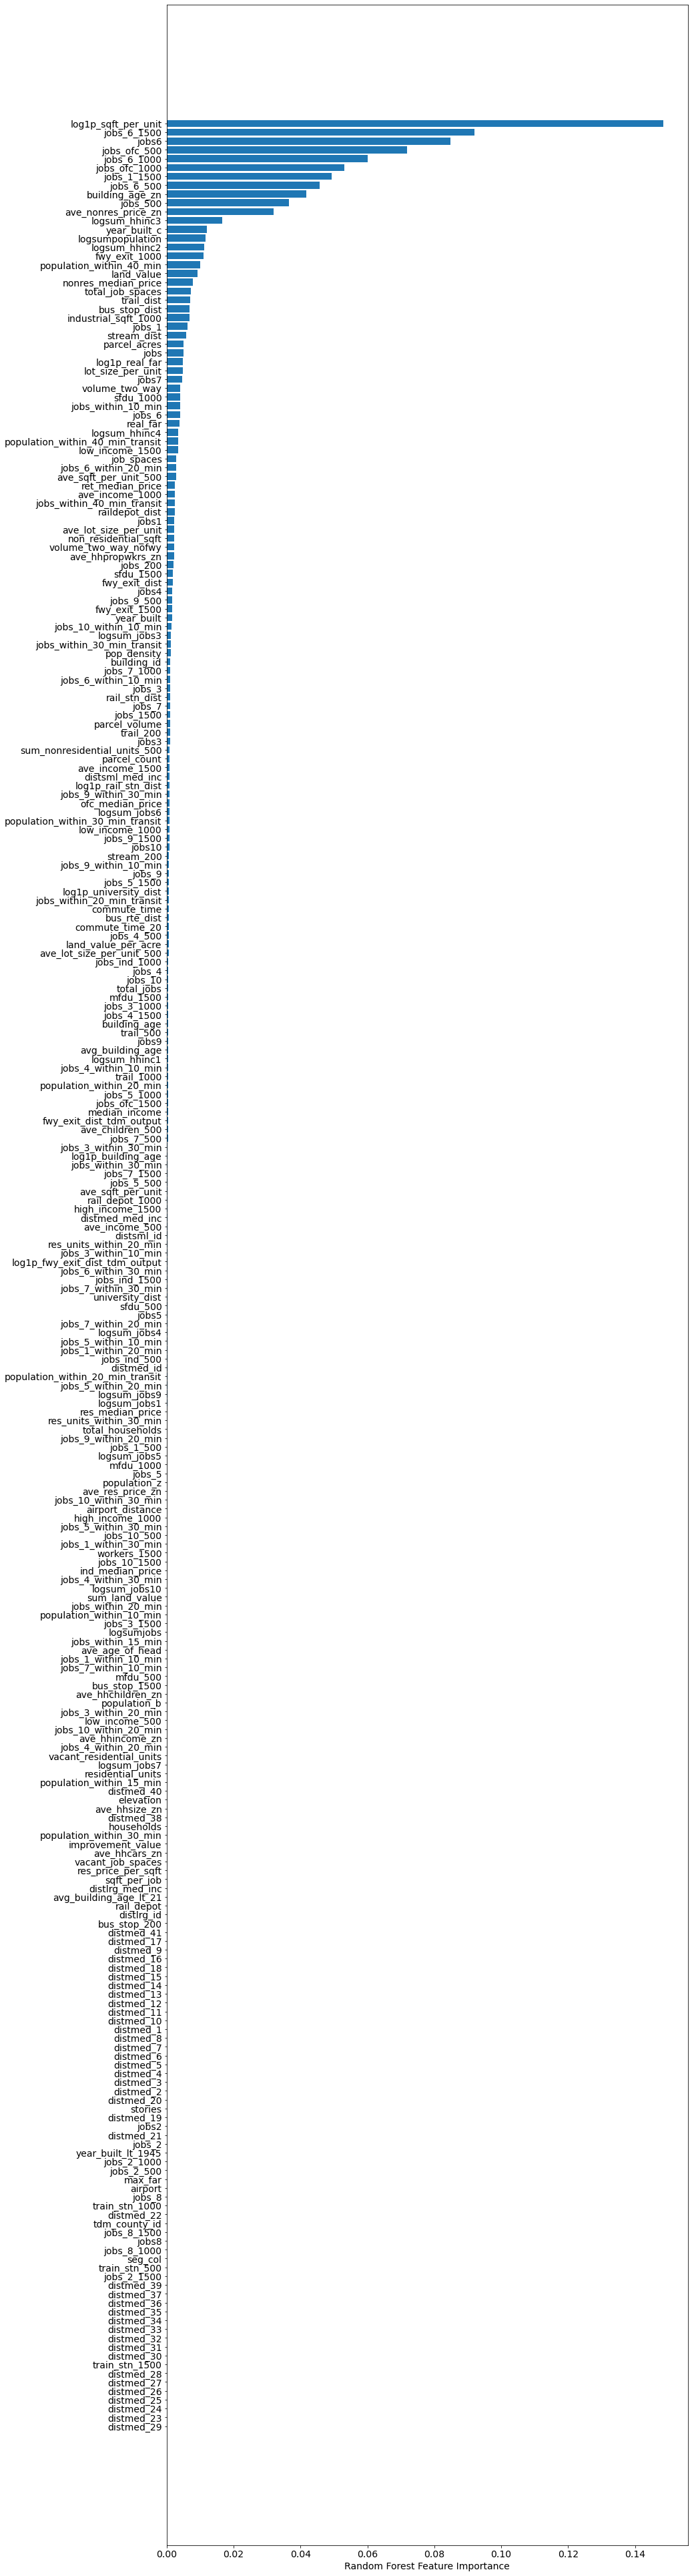

In [338]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Industrial

###  Weber & Davis

In [339]:
# arguments - check these
data = pd.concat([comm_57, comm_11])
y_var_name = 'unit_price_non_residential_c'

In [340]:
# filters
ind = data[(data['building_type_id_c'] == 3) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
ind.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = ind.copy()
y_var = ind[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:136
Testing sample size:46


In [341]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 239764.575
Mean Squared Error: 1284751036765.848
R-squared scores: 0.047


Text(0.5, 0, 'Random Forest Feature Importance')

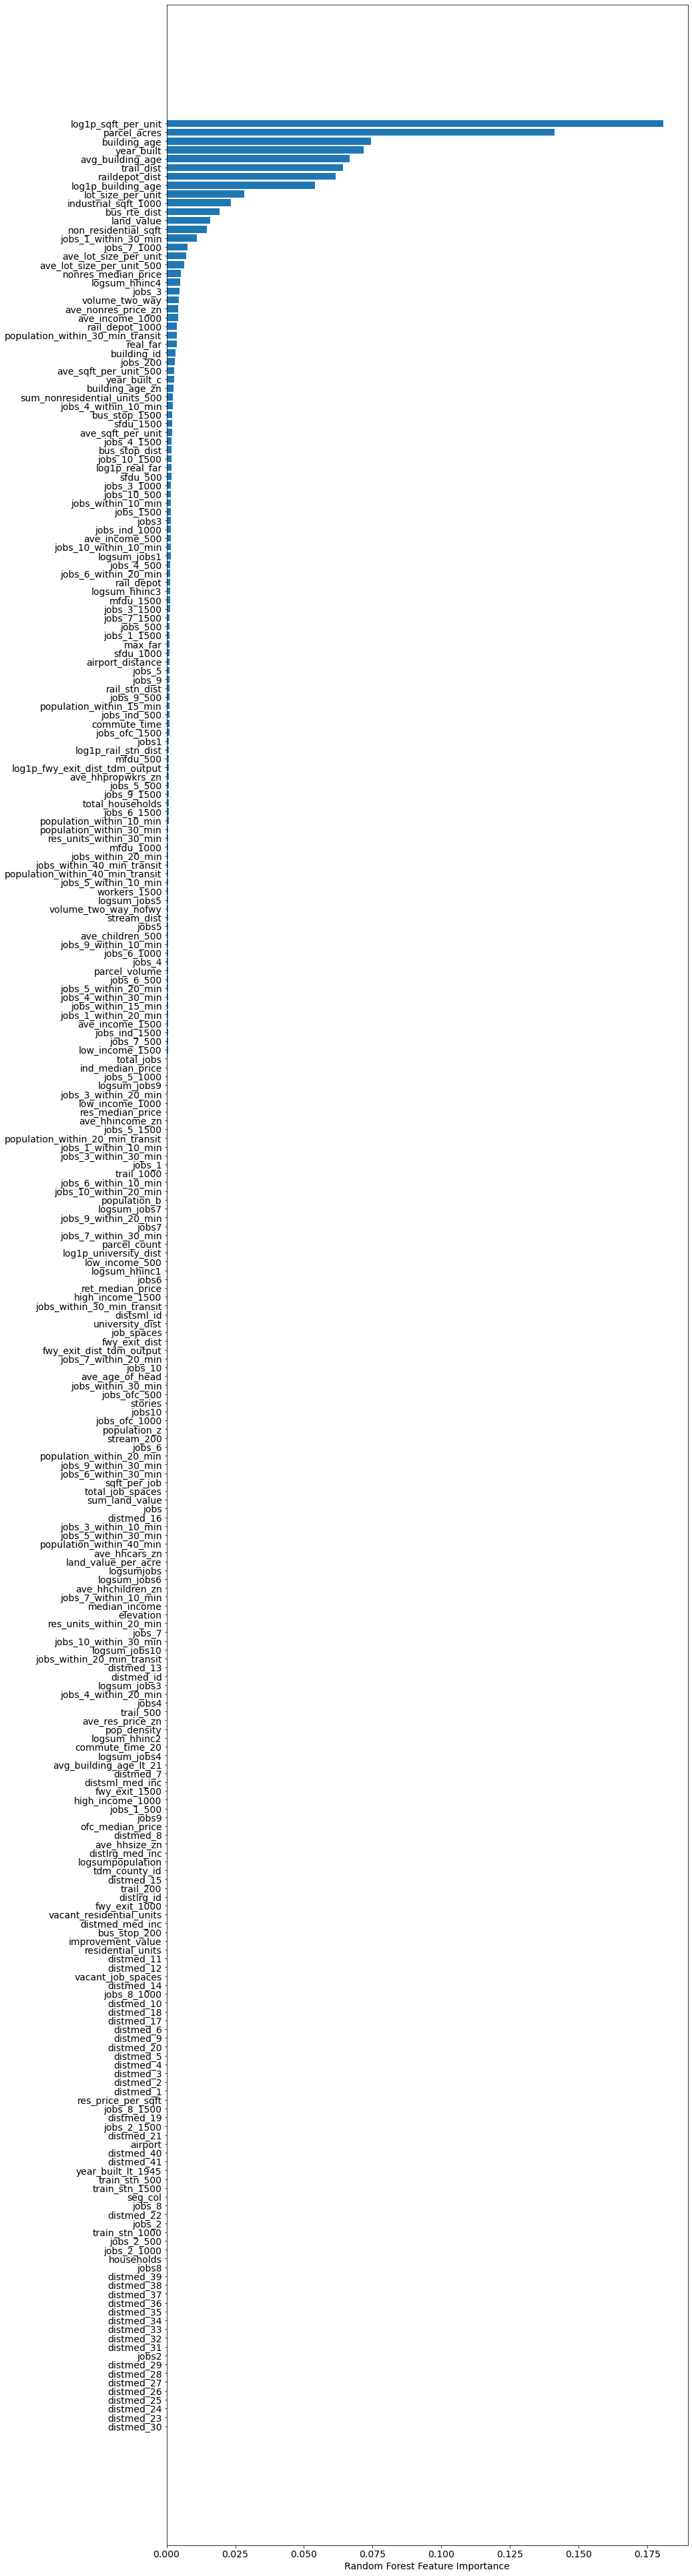

In [342]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [343]:
# arguments - check these
data = comm_35
y_var_name = 'unit_price_non_residential_c'

In [344]:
# filters
ind = data[(data['building_type_id_c'] == 3) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
ind.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = ind.copy()
y_var = ind[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:673
Testing sample size:225


In [345]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 143688.284
Mean Squared Error: 72954074086.418
R-squared scores: 0.756


Text(0.5, 0, 'Random Forest Feature Importance')

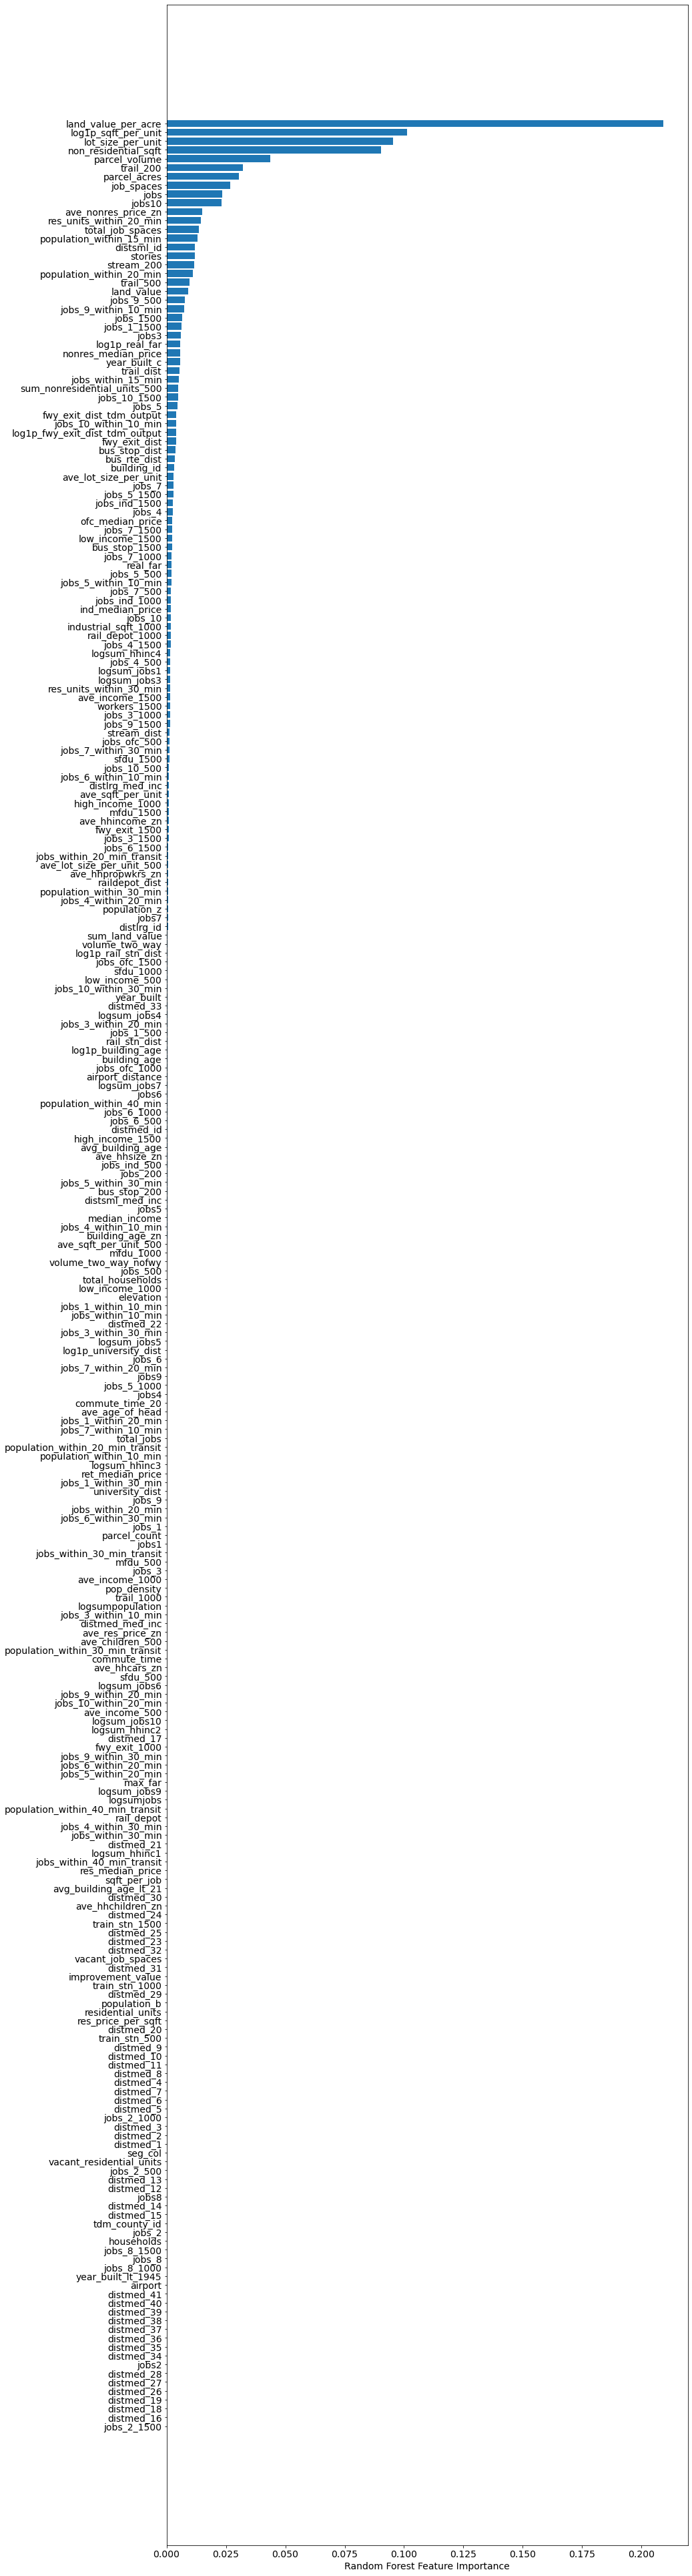

In [346]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [347]:
# arguments - check these
data = comm_49
y_var_name = 'unit_price_non_residential_c'

In [348]:
ind

building_id  residential_units  non_residential_sqft  \
13032         31324                0.0                9863.0   
13616         31930                0.0               12950.0   
13617         31930                0.0               12950.0   
13618         31930                0.0               12950.0   
13619         31930                0.0               12950.0   
...             ...                ...                   ...   
36098         53331                0.0              120903.0   
36099         53331                0.0              120903.0   
36553         55429                0.0               12587.0   
411164       445145                1.0                   0.0   
422841       456851              178.0                   0.0   

        res_price_per_sqft  year_built  stories  job_spaces  \
13032             0.000000      1942.0      0.0         0.0   
13616             0.000000      1955.0      1.0        11.0   
13617             0.000000      1955.0      1.0        11.0   
13618             0.000000      1955.0      1.0        11.0   
13619             0.000000      1955.0      1.0        11.0   
...                    ...         ...      ...         ...   
36098             0.000000      1957.0      1.0       193.0   
36099             0.000000      1957.0      1.0       193.0   
36553             0.000000      2007.0      1.0        39.0   
411164           47.788426      2018.0      1.0         0.0   
422841          113.962757      1965.0      1.0         0.0   

        lot_size_per_unit  sqft_per_job  vacant_residential_units  \
13032       138635.105900           350                       0.0   
13616       314797.350100           350                       0.0   
13617       314797.350100           350                       0.0   
13618       314797.350100           350                       0.0   
13619       314797.350100           350                       0.0   
...                   ...           ...                       ...   
36098        44434.210970           633                       0.0   
36099        44434.210970           633                       0.0   
36553        38437.685690           300                       0.0   
411164        4047.662613           200                       0.0   
422841        5100.833891           200                       2.0   

        vacant_job_spaces  distlrg_id  distmed_id  distsml_id  distmed_1  \
13032                 0.0           6          17         158          0   
13616                 0.0           7          21         190          0   
13617                 0.0           7          21         190          0   
13618                 0.0           7          21         190          0   
13619                 0.0           7          21         190          0   
...                   ...         ...         ...         ...        ...   
36098                 0.0           8          23         234          0   
36099                 0.0           8          23         234          0   
36553                 0.0          11          31         374          0   
411164                0.0          11          32         394          0   
422841                0.0           7          22         197          0   

        distmed_2  distmed_3  distmed_4  distmed_5  distmed_6  distmed_7  \
13032           0          0          0          0          0          0   
13616           0          0          0          0          0          0   
13617           0          0          0          0          0          0   
13618           0          0          0          0          0          0   
13619           0          0          0          0          0          0   
...           ...        ...        ...        ...        ...        ...   
36098           0          0          0          0          0          0   
36099           0          0          0          0          0          0   
36553           0          0          0          0      

In [349]:
# filters
ind = data[(data['building_type_id_c'] == 3) & (data['unit_price_non_residential_c'] > 0)].copy()

# drop unneeded columns
ind.drop(drop_vars, axis=1, inplace=True)

# separate independent and dependent variables
x_vars = ind.copy()
y_var = ind[y_var_name]
x_vars.drop([y_var_name], axis=1, inplace=True)

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=seed)
print("Training sample size:{}".format(int(x_train.shape[0])))
print("Testing sample size:{}".format(int(x_test.shape[0])))

Training sample size:85
Testing sample size:29


In [350]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=150)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 78177.546
Mean Squared Error: 13688227990.063
R-squared scores: 0.843


Text(0.5, 0, 'Random Forest Feature Importance')

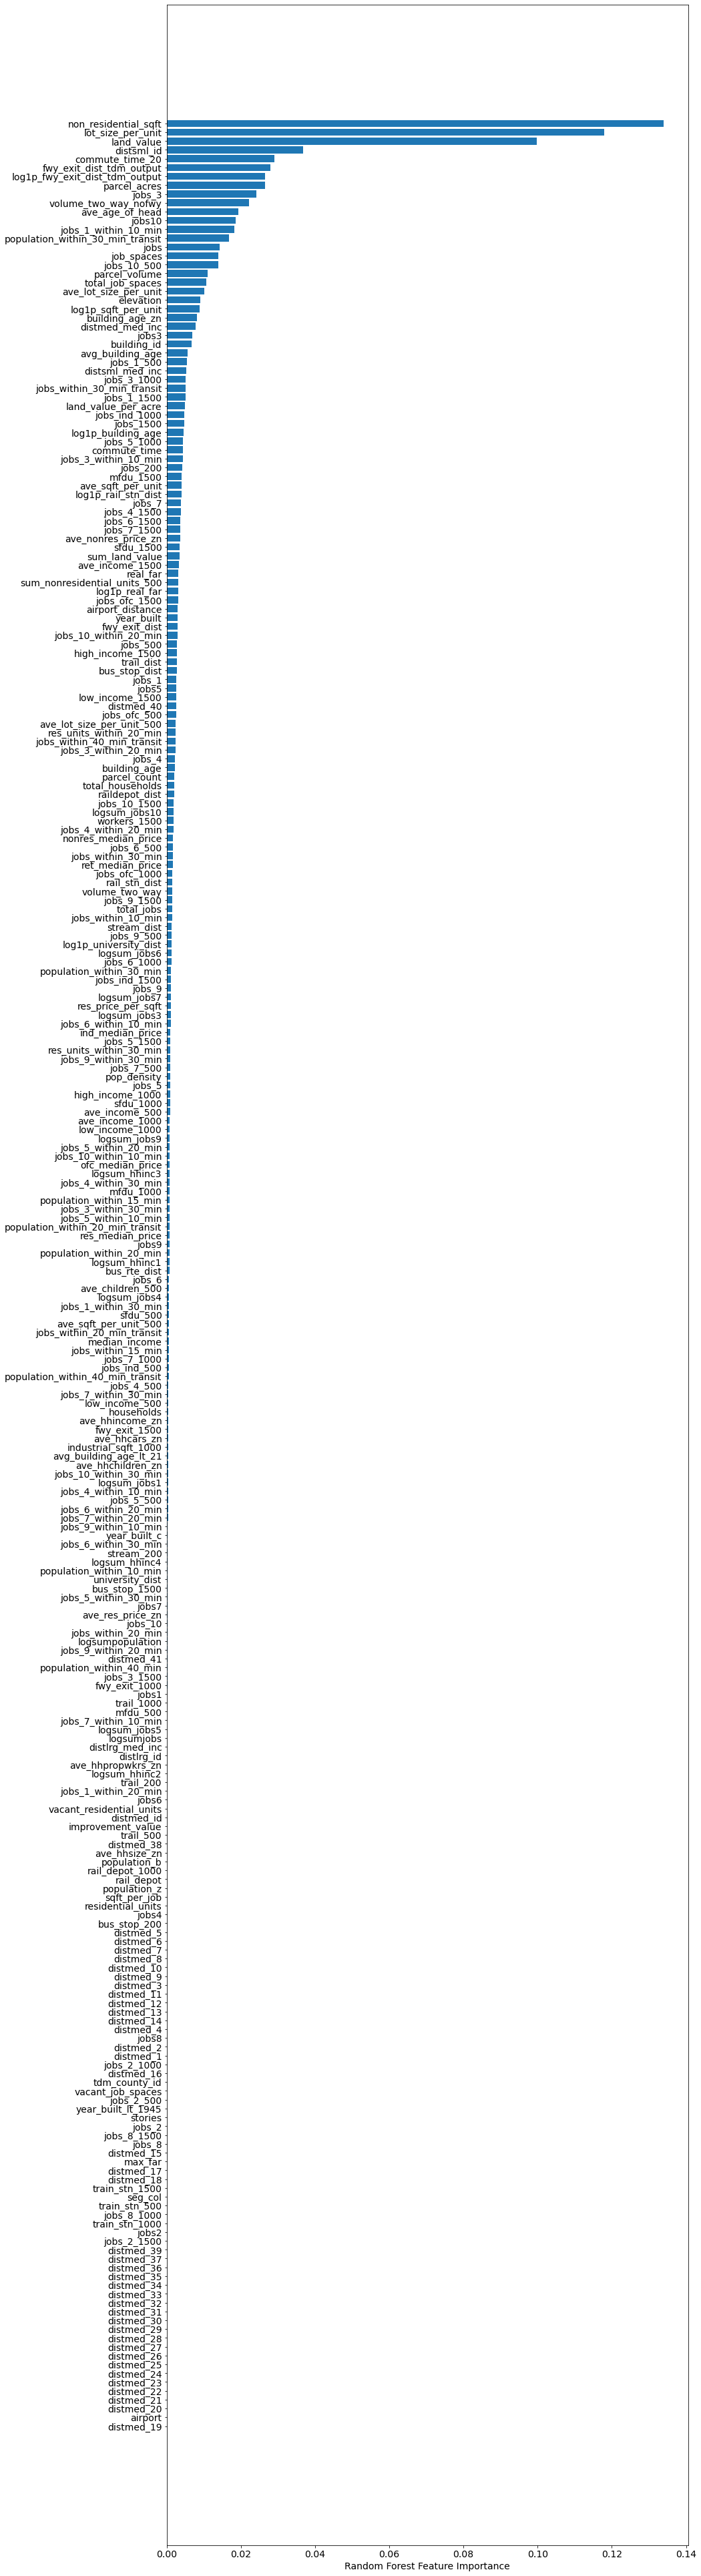

In [351]:
#===========================================
# show variable importance chart
#===========================================

sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")